In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick

sns.set_style('darkgrid')
import sys
import os

os.chdir(r'C:\Users\mlentini\OneDrive - Edmund Optics, Inc\Documents\Data Projects\Projects for Gregg\AB Testing Multipricing')

sns.set_style('darkgrid')

# Thompson Sampling
https://github.com/iosband/ts_tutorial

https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

#
Simulation study:

In [7]:
# pulling the slot machine levers we do not know with certainty which of these levers
# has the higgest expected reward. In the case of Bernoulli variables, the highest expected
# reward is given by the pr. of succeeding, theta.

# suppose the ground truth is given by
theta1 = 0.9
theta2 = 0.8
theta3 = 0.7

# initialize prior
a1, b1 = 1, 1
a2, b2 = 1, 1
a3, b3 = 1, 1

T = 1000
for t in range(T):
    # sample from prior
    theta1_, theta2_, theta3_ = stats.beta.rvs(a1, b1), stats.beta.rvs(a2, b2), stats.beta.rvs(a3, b3)

    # select best action
    x = np.argmax(np.array([theta1_, theta2_, theta3_]))

    # apply action,  observe rewards and update distrubtion
    if x == 0:
        r = stats.binom.rvs(1, theta1)
        a1, b1 = (a1 + r), (b1 + 1 - r)
        if a1 == 0:
            a1 = sys.float_info.min
        if b1 == 0:
            b1 = sys.float_info.min
    elif x == 1:
        r = stats.binom.rvs(1, theta2)
        a2, b2 = (a2 + r), (b2 + 1 - r)
        if a2 == 0:
            a2 = sys.float_info.min
        if b2 == 0:
            b2 = sys.float_info.min
    else:
        r = stats.binom.rvs(1, theta3)
        a3, b3 = (a3 + r), (b3 + 1 - r)
        if a3 == 0:
            a3 = sys.float_info.min
        if b3 == 0:
            b3 = sys.float_info.min

#### Visualize updates
Convergence is when the algorithm realizes who the winner is most likely to be, not when the error in the mean estimations for each curve is minimized.

0.9015006437047144
0.6958112499665255
0.6376421831980176


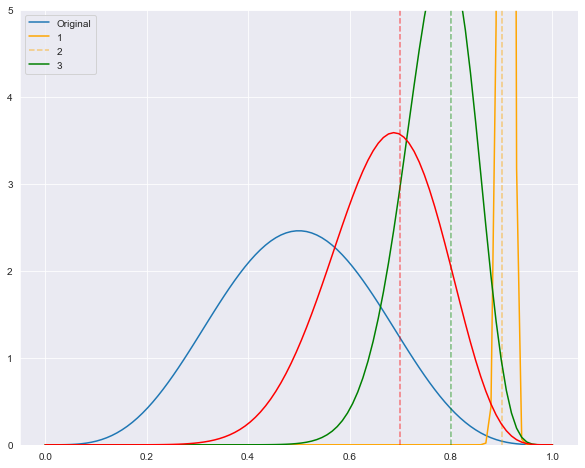

In [8]:
# plot prior beta distribution
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 1, 100)
ax.plot(x, stats.beta.pdf(x, 5, 5))

# plot update priors
if a1:
    ax.plot(x, stats.beta.pdf(x, a1, b1), c='orange')
    ax.axvline(theta1, c='orange', linestyle='--', alpha=0.5)
if a2:
    ax.plot(x, stats.beta.pdf(x, a2, b2), c='g')
    ax.axvline(theta2, c='g', linestyle='--', alpha=0.5)
if a3:
    ax.plot(x, stats.beta.pdf(x, a3, b3), c='r')
    ax.axvline(theta3, c='r', linestyle='--', alpha=0.5)
    
ax.set_ylim(0, 5)
ax.legend(['Original', '1', '2', '3'])

print(theta1_)
print(theta2_)
print(theta3_)

plt.show()

# Test Poisson-Gamma Thompson Sampling on Multipricing

# 
Measure demand simply as quantity purchased. We only have two prices to test, which are the two "arms" of the system. 

https://gist.github.com/eigenfoo/e9a9933d94524e6dee717276c6b6f732

#### Simulation

In [10]:
np.random.poisson(lam=[2, 3, 4], size=len([2, 3, 4]))

array([3, 5, 3])

In [2]:
def make_bandits(params):
    def pull(arm, size=None):
        while True:
            # Poisson distributed rewards
            reward = np.random.poisson(lam=params[arm], size=size)
            yield reward
    
    return pull, len(params)


def bayesian_strategy(pull, num_bandits, price):
    # prior parameters
    num_rewards = price[1]*np.ones(num_bandits)
    num_trials = np.ones(num_bandits)
    
    while True:
        # Sample from the bandits' priors, and choose largest revenue
        choice = np.argmax(price*np.random.gamma(num_rewards,
                                           scale=1/num_trials))
        
        # Sample the chosen bandit
        reward = next(pull(choice))
        
        # Update
        num_rewards[choice] += reward
        num_trials[choice] += 1
        
        yield choice, reward, num_rewards, num_trials

             0       1      2
Price     12.5    8.75   6.25
Demand    10.0   13.00  15.00
Revenue  125.0  113.75  93.75


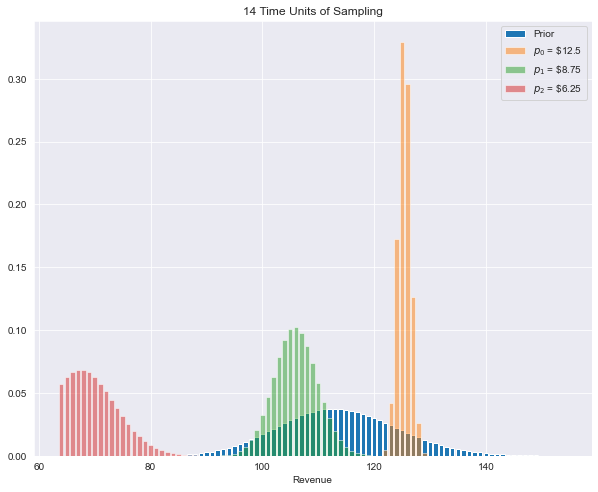

In [26]:
# suppose demand is a linear model of price
a = 20
b = 0.8
# q = a - b*price

q = np.array([10, 13, 15])
price = (a - q)/b

# print ground truth
print(pd.DataFrame(np.array([price, q, q*price]), index=['Price', 'Demand', 'Revenue']))

# sample 100 times
pull, num_bandits = make_bandits([10, 13, 15]) # average amount that we would see for each price
play = bayesian_strategy(pull, num_bandits, price=price)

# change price every day for 14 days
n_trials = 100
for _ in range(n_trials):
    choice, reward, num_rewards, num_trials = next(play)

# plots
fig, ax = plt.subplots(figsize=(10, 8))

x = np.arange(np.min(q*price).round() - 30, np.max(q*price).round() + 30).astype(int)

# Poisson liklihood
ax.bar(x, stats.gamma.pdf(x, price[1]*q[1], 0), alpha=1)

#plot all three arms
ax.bar(x, stats.gamma.pdf(x, price[0]*num_rewards[0], loc=0, scale=1/num_trials[0]), alpha=0.5)
ax.bar(x, stats.gamma.pdf(x, price[1]*num_rewards[1], loc=0, scale=1/num_trials[1]), alpha=0.5)
ax.bar(x, stats.gamma.pdf(x, price[2]*num_rewards[2], loc=0, scale=1/num_trials[2]), alpha=0.5)

ax.set_label('Quantity Demanded')

# posterior distribution is gamma, same a prior, therefore Poisson is conjugate prior for the Gamma
plt.legend([
    'Prior', 
    '$p_0$ = {}'.format('\$' + str(price[0])), 
    '$p_1$ = {}'.format('\$' + str(price[1])), 
    '$p_2$ = {}'.format('\$' + str(price[2]))
])

plt.title('14 Time Units of Sampling')
plt.xlabel('Revenue')
plt.show()

#### Real Data

In [7]:
# multipricing test data
data = pd.read_csv('multipricing_all_tiers_all_fams.csv')

# test 2021 vs 2022
data.date = pd.to_datetime(data.date)
data = data[data.date.dt.year >= 2021]
data['month'] =  data['date'].dt.to_period('M')
data['year'] = data.date.dt.year
data['month_str'] =  data['date'].dt.to_period('M').astype(str)

# select tested families
fams = [2956, 3044, 3227, 2076]
ctrl = [2684, 3403, 2955, 1923]
data = data[data.ProductFamilyID.isin(fams + ctrl)]

# new columns
data['avg_qty'] = (data.quantity/data.orders).fillna(0)
data['is_2022'] = (data.date.dt.year == 2022).astype(int)
data['treated'] = (data.ProductFamilyID.isin(fams)).astype(int)

# discount is 20% unless otherwise specified
data['discount'] = 0.2
data.loc[
    (data.treated == 1) &
    (data.is_2022 == 0),
    'discount'
] = 0.2

disc_2022 = [0.1, .125, .125, .15]
for i in np.arange(len(fams)):
    data.loc[
        (data.treated == 1) &
        (data.is_2022 == 1) &
        (data.ProductFamilyID == fams[i]),
        'discount'
    ] = disc_2022[i]

data.head()

date  ProductFamilyID  Tier  profit  revenue  orders  customers  \
39840 2021-12-06             3403     1     0.0      0.0       0          0   
39842 2021-02-14             3403     1     0.0      0.0       0          0   
39843 2021-08-02             3403     1     0.0      0.0       0          0   
39846 2021-12-23             3403     1     0.0      0.0       0          0   
39849 2021-11-30             3403     1   806.2   1442.5       2          0   

       quantity  customers_all_tiers           tested_through    month  year  \
39840         0                    0  2022-06-13 16:41:51.870  2021-12  2021   
39842         0                    0  2022-06-13 16:41:51.870  2021-02  2021   
39843         0                    0  2022-06-13 16:41:51.870  2021-08  2021   
39846         0                    0  2022-06-13 16:41:51.870  2021-12  2021   
39849         6                    0  2022-06-13 16:41:51.870  2021-11  2021   

      month_str  avg_qty  is_2022  treated  discount  
39840   2021-12      0.0        0        0       0.2  
39842   2021-02      0.0        0        0       0.2  
39843   2021-08      0.0        0        0       0.2  
39846   2021-12      0.0        0        0       0.2  
39849   2021-11      3.0        0        0       0.2

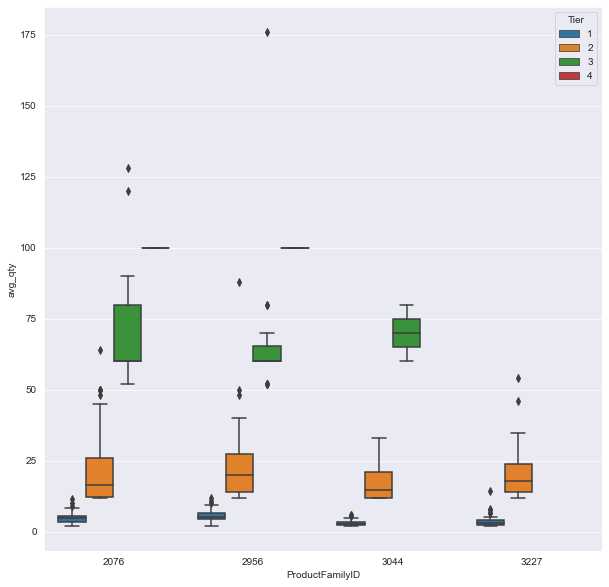

In [4]:
# plot quantity by tiers boxplot
fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(
    data=data[
        (data.quantity != 0) &
        (data.ProductFamilyID.isin(fams))
    ],
    x='ProductFamilyID',
    y='avg_qty',
    hue='Tier'
)

plt.show()

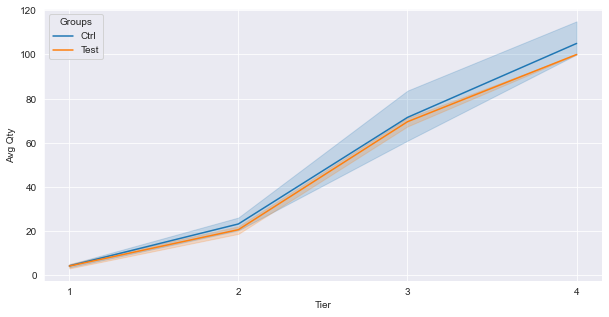

In [4]:
# are price breaks different between skus within a PID?
fig, ax = plt.subplots(figsize=(10, 5))

x = data.loc[
    (data.quantity != 0) &
    (data.ProductFamilyID.isin(fams + ctrl))
].groupby(['ProductFamilyID', 'Tier', 'treated'], as_index=False)['avg_qty'].mean()

# rename treated columns
x.rename(columns={'treated':'Groups'}, inplace=True)
x.Groups = x.Groups.replace({0:'Ctrl', 1:'Test'})

sns.lineplot(
    data=x,
    x='Tier',
    y='avg_qty',
    hue='Groups'
)

ax.set_xticks([1, 2, 3, 4])
ax.set_ylabel('Avg Qty')
plt.show()

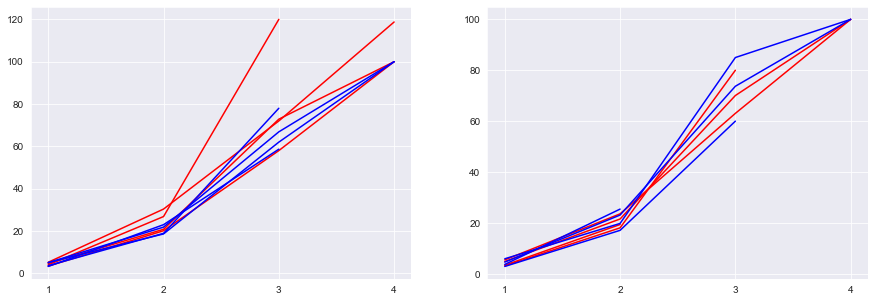

In [71]:
# are price breaks different between skus within a PID?
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# get data
x = data.loc[
    (data.quantity != 0) &
    (data.ProductFamilyID.isin(fams + ctrl))
].groupby(['ProductFamilyID', 'Tier', 'treated', 'year'], as_index=False)['avg_qty'].mean()

# plot
colors = ['red', 'blue']
for j in [0, 1]:
    i = 0
    x_ = x[x.treated == j]
    for year in x.year.unique():
        color = colors[i]
        i +=1
        for pid in x_.ProductFamilyID.unique():
            x__ = x_[(x_.year == year) & (x_.ProductFamilyID == pid)]
            ax[j].plot(x__.Tier, x__.avg_qty, color=color)
            ax[j].set_xticks([1, 2, 3, 4])

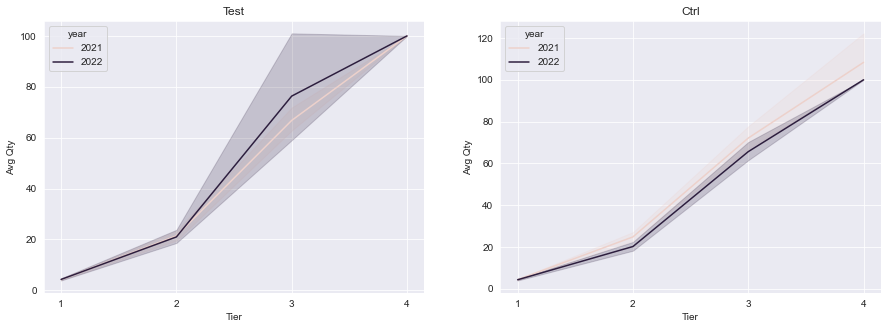

In [62]:
# did tier distribution change?
fig, ax = plt.subplots(figsize=(15, 5))

x = data.loc[
    (data.quantity != 0) &
    (data.ProductFamilyID.isin(fams + ctrl))
].copy()#.groupby(['ProductFamilyID', 'Tier', 'treated', 'year'], as_index=False)['avg_qty'].mean()


# rename treated columns
x.rename(columns={'treated':'Groups'}, inplace=True)
x.Groups = x.Groups.replace({0:'Ctrl', 1:'Test'})

groups = ['Test', 'Ctrl']
for i in [1, 2]:
    ax = plt.subplot(1, 2, i)
    sns.lineplot(
        data=x[x.Groups == '{}'.format(groups[i-1])],
        x='Tier',
        y='avg_qty',
        hue='year',
        ax = ax
    )
    
    ax.set_title('{}'.format(groups[i-1]))    
    ax.set_xticks([1, 2, 3, 4])
    ax.set_ylabel('Avg Qty')
    
plt.show()

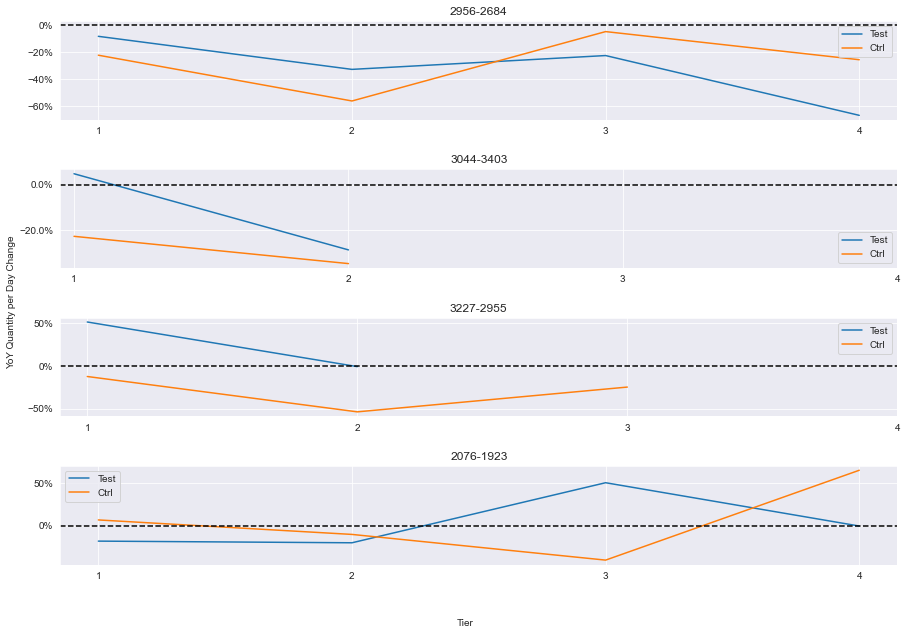

In [28]:
# dataframe to store results
results = pd.DataFrame()
#results['Tier'] = [1, 2, 3, 4]

# compare against YTD 2021
today = data.date.max()
today_last_year = today - pd.Timedelta(365, "day")
    

x = data.loc[
    #(data.quantity != 0) &
    (data.ProductFamilyID.isin(fams + ctrl)) &
    (
        (data.date.dt.year == 2022) | 
        (data.date <= today_last_year)
    )
].copy()

# get results
for pid in x.ProductFamilyID.unique():
    pct_change = []
    for t in [1, 2, 3, 4]:
        x_ = x[
            (x.ProductFamilyID == pid) &
            (x.Tier == t)
        ].copy()
        
        
        qty2022 = x_.loc[x_.year == 2022, 'quantity'].mean()
        qty2021 = x_.loc[x_.year == 2021, 'quantity'].mean()
        
        if qty2021 != 0:
            pct_change.append((qty2022 - qty2021)/qty2021)
        else:
            pct_change.append(np.nan)
        
    results[str(pid)] = pct_change

results = results*100

# create figure
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# plot test vs ctrl differences in tier from 2022 to 2021
for i in range(len(fams)):
    
    ax = plt.subplot(4, 1, i+1)
    
    # plot
    results[str(fams[i])].plot(ax=ax)
    results[str(ctrl[i])].plot(ax=ax)
            
    ax.legend(['Test', 'Ctrl'])
    ax.set_title('{}'.format(str(fams[i])) + '-' + '{}'.format(str(ctrl[i])))
    
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels([1, 2, 3, 4])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # horizontal line at y = 0
    ax.axhline(0, linestyle='--', color='black')

fig.text(0.08, 0.4, 'YoY Quantity per Day Change', ha='center', rotation = 90)
fig.text(0.5, 0.04, 'Tier', ha='center')
plt.show()

In [30]:
results.iloc[1, :] - results.iloc[0, :]

p = []
for i in range(len(fams)):
    d2 = results[str(fams[i])][1] - results[str(fams[i])][0]
    d1 = results[str(ctrl[i])][1] - results[str(ctrl[i])][0]
    
    p.append(d2 - d1)
    print(d2 - d1)
    
print(np.mean(p))
results

9.464139768686508
-21.64561215708666
-10.87183261925761
15.233506980952804
-1.9549495066762397


3403       2684       2076       2955       2956       3227  \
0 -22.838243 -22.118622 -18.551227 -12.227054  -8.063428  51.680987   
1 -34.917702 -56.183972 -20.512821 -53.677235 -32.664638  -0.641026   
2        NaN  -4.544414  50.791855 -24.624226 -22.375801        NaN   
3        NaN -25.480769  -0.641026        NaN -66.880342        NaN   

        3044       1923  
0   4.878917   6.606335  
1 -28.846154 -10.588766  
2        NaN -41.090444  
3        NaN  65.598291

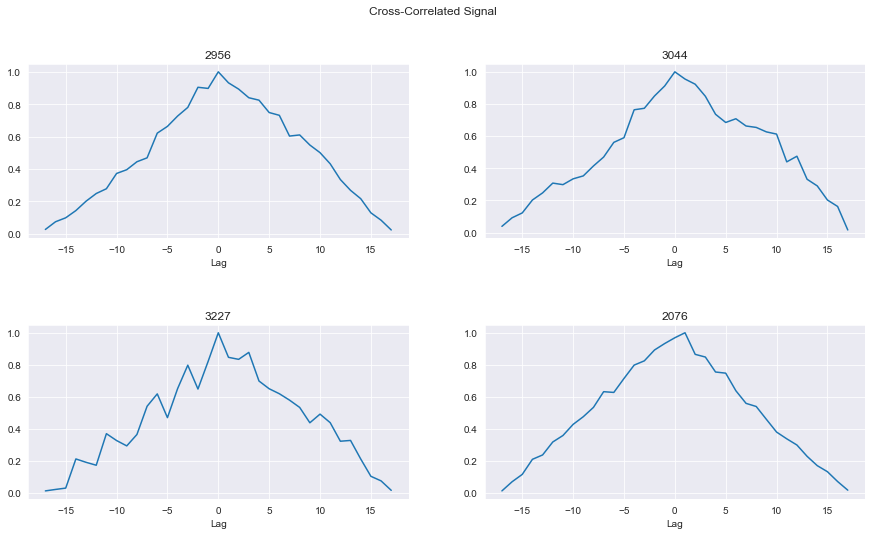

In [40]:
# check cross-correlation between tier 1 and tier 2 sales
# cross-correlation between tier 1 demand and tier 2?
from scipy import signal
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

# group by month
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier'], as_index=False)['quantity'].sum()

# get cross correlation and lags
for i in range(len(fams)):
    ax = plt.subplot(2, 2, i + 1)
    tier1_qty = data_.sort_values('month_str').loc[(data_.Tier == 1) & (data_.ProductFamilyID == fams[i]), 'quantity']
    tier2_qty = data_.sort_values('month_str').loc[(data_.Tier == 2) & (data_.ProductFamilyID == fams[i]), 'quantity']

    corr = signal.correlate(tier1_qty, tier2_qty)
    lags = signal.correlation_lags(len(tier1_qty), len(tier2_qty))

    # normalize correlation
    corr = corr/np.max(corr)

    # labels
    plt.plot(lags, corr)
    ax.set_xlabel('Lag')
    ax.set_title('{}'.format(fams[i]))
    
plt.suptitle('Cross-Correlated Signal')

plt.show()

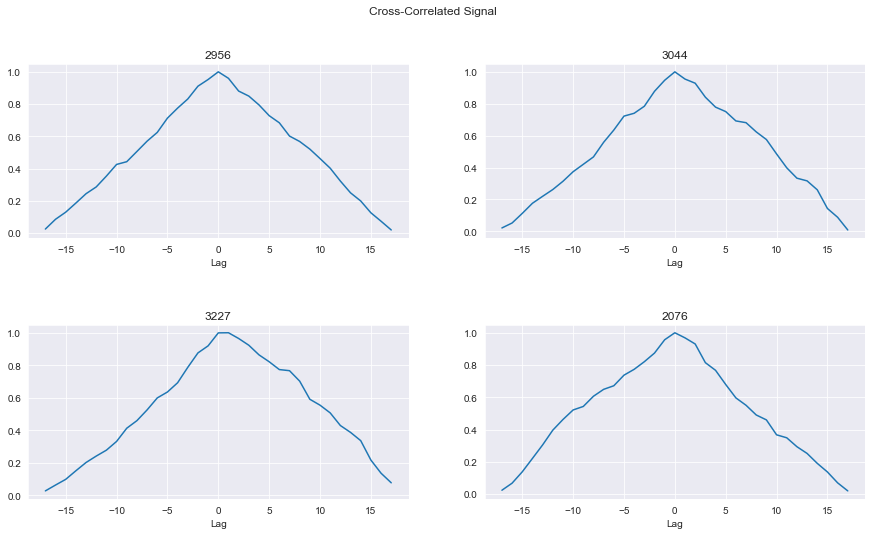

In [39]:
# check cross-correlation between tier 1 and test and ctrl quantity demand
# cross-correlation between tier 1 demand and tier 2?
from scipy import signal
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

# group by month
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier'], as_index=False)['quantity'].sum()

# get cross correlation and lags
for i in range(len(fams)):
    ax = plt.subplot(2, 2, i + 1)
    tier1_qty = data_.sort_values('month_str').loc[(data_.Tier == 1) & (data_.ProductFamilyID == fams[i]), 'quantity']
    tier2_qty = data_.sort_values('month_str').loc[(data_.Tier == 1) & (data_.ProductFamilyID == ctrl[i]), 'quantity']

    corr = signal.correlate(tier1_qty, tier2_qty)
    lags = signal.correlation_lags(len(tier1_qty), len(tier2_qty))

    # normalize correlation
    corr = corr/np.max(corr)

    # labels
    plt.plot(lags, corr)
    ax.set_xlabel('Lag')
    ax.set_title('{}'.format(fams[i]))
    
plt.suptitle('Cross-Correlated Signal')

plt.show()

In [88]:
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier', 'is_2022', 'treated'], as_index=False)['quantity'].sum()
x = data_.pivot_table(index=['month_str', 'ProductFamilyID', 'is_2022', 'treated'], columns='Tier', values='quantity', aggfunc=sum).reset_index().copy()
x['Tier 2/Tier 1'] = x[2]/x[1]

import statsmodels.api as sm
from statsmodels.formula.api import ols

# tier
i = 3
x = x.rename(columns={1:'T1', 2: 'T2'})
model = ols('T2 ~ T1 + C(ProductFamilyID) + treated*is_2022', data=x).fit()#[x.ProductFamilyID.isin([fams[i], ctrl[i]])]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     34.76
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           2.09e-32
Time:                        08:38:55   Log-Likelihood:                -800.80
No. Observations:                 144   AIC:                             1624.
Df Residuals:                     133   BIC:                             1656.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [111]:
# use discount instead of binary treatment variable
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier', 'is_2022', 'discount'], as_index=False)['quantity'].sum()
x = data_.pivot_table(index=['month_str', 'ProductFamilyID', 'is_2022', 'discount'], columns='Tier', values='quantity', aggfunc=sum).reset_index().copy()
x['Tier 2/Tier 1'] = x[2]/x[1]

import statsmodels.api as sm
from statsmodels.formula.api import ols

# tier
i = 3
x = x.rename(columns={1:'T1', 2: 'T2'})
model = ols('T2 ~ T1 + C(ProductFamilyID) + discount*is_2022', data=x).fit()#[x.ProductFamilyID.isin([fams[i], ctrl[i]])]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     34.42
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           3.30e-32
Time:                        09:46:06   Log-Likelihood:                -801.31
No. Observations:                 144   AIC:                             1625.
Df Residuals:                     133   BIC:                             1657.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [112]:
x

Tier month_str  ProductFamilyID  is_2022  discount   T1   T2    3    4  \
0      2021-01             1923        0     0.200  154  178  132  100   
1      2021-01             2076        0     0.200   54  136    0    0   
2      2021-01             2684        0     0.200  150  330  128    0   
3      2021-01             2955        0     0.200  126   70   60    0   
4      2021-01             2956        0     0.200  234  268  160    0   
..         ...              ...      ...       ...  ...  ...  ...  ...   
139    2022-06             2955        1     0.200   48   30    0    0   
140    2022-06             2956        1     0.100   74   96   52    0   
141    2022-06             3044        1     0.125   16   30    0    0   
142    2022-06             3227        1     0.125   84   14    0    0   
143    2022-06             3403        1     0.200   38    0    0    0   

Tier  Tier 2/Tier 1  
0          1.155844  
1          2.518519  
2          2.200000  
3          0.555556  
4          1.145299  
..              ...  
139        0.625000  
140        1.297297  
141        1.875000  
142        0.166667  
143        0.000000  

[144 rows x 9 columns]

In [93]:
-200.9830*np.array([0.10, 0.125, 0.15])

print(-495.227*np.array([0.10, 0.125, 0.15]))
print(93.261*np.array([0.10, 0.125, 0.15]))

[-49.5227   -61.903375 -74.28405 ]
[ 9.3261   11.657625 13.98915 ]


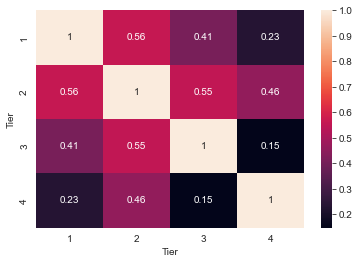

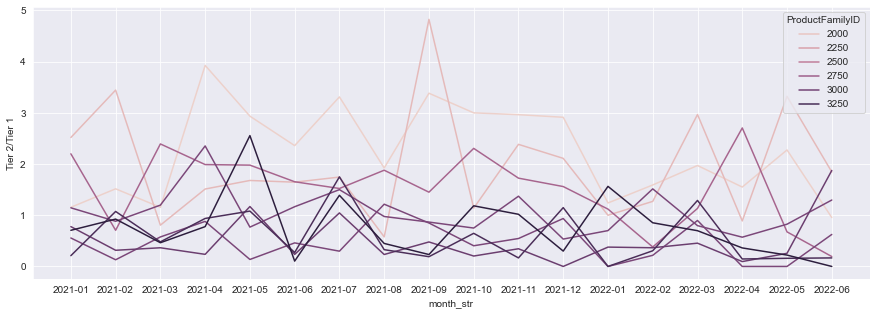

In [77]:
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier', 'is_2022', 'treated'], as_index=False)['quantity'].sum()
x = data_.pivot_table(index=['month_str', 'ProductFamilyID', 'is_2022', 'treated'], columns='Tier', values='quantity', aggfunc=sum).reset_index().copy()
x['Tier 2/Tier 1'] = x[2]/x[1]

sns.heatmap(x[[1, 2, 3, 4]].corr(), annot=True)
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=x, y='Tier 2/Tier 1', x='month_str', hue='ProductFamilyID', ax=ax)

plt.show()

In [ ]:
# qq-plot ctrl vs test
steps = 100
ctrl_quantiles = [data.loc[(data.is_2022 == 0) & (data.Tier == 2), 'avg_qty'].quantile(x) for x in np.linspace(0, 1, steps)]
test_quantiles = [data.loc[(data.is_2022 == 1) & (data.Tier == 2), 'avg_qty'].quantile(x) for x in np.linspace(0, 1, steps)]

ax[1].scatter(ctrl_quantiles, test_quantiles, alpha=0.8)

# add line slope 1
x = np.linspace(min([min(ctrl_quantiles), min(test_quantiles)]), max([max(ctrl_quantiles), max(test_quantiles)]))
ax[1].plot(x, x, c='red', linestyle='--', alpha=0.5)
ax[1].set_title('QQ-Plot Average Quantity Pre vs Post')

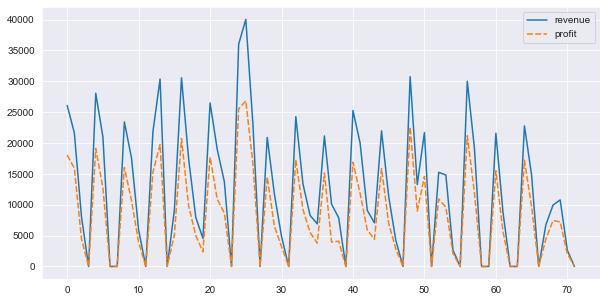

In [170]:
import datetime as dt
dt.date(2021, 1, 1)

# revenue vs profit
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(
        data=data[data.ProductFamilyID == fams[0]]\
            .sort_values('date', ascending=True)\
            .groupby(['month', 'Tier'], as_index=False).sum('quantity')[['revenue', 'profit']],
    ax=ax
    )

plt.show()

In [41]:
data[data.ProductFamilyID == fam]\
            .sort_values('date', ascending=True)\
            .groupby(['month_str', 'Tier'], as_index=False).sum('quantity')

month_str  Tier  ProductFamilyID    profit   revenue  orders  customers  \
0    2021-01     1            79812  18049.02  26085.92      46         37   
1    2021-01     2            79812  15918.56  21665.80       9          9   
2    2021-01     3            79812   4464.48   8057.92       2          2   
3    2021-01     4            79812      0.00      0.00       0          0   
4    2021-02     1            79812  19104.28  28064.60      45         34   
..       ...   ...              ...       ...       ...     ...        ...   
67   2022-05     4            85724   4432.00   6755.00       1          1   
68   2022-06     1            23648   5625.42   7600.70       9          6   
69   2022-06     2            23648   5795.76   8718.00       3          2   
70   2022-06     3            23648   2065.96   2640.56       1          0   
71   2022-06     4            23648      0.00      0.00       0          0   

    quantity  customers_all_tiers  is_2022  treated  
0        234                   37        0       27  
1        268                    9        0       27  
2        160                    2        0       27  
3          0                    0        0       27  
4        238                   34        0       27  
..       ...                  ...      ...      ...  
67       100                    1       29       29  
68        52                    6        8        8  
69        76                    2        8        8  
70        52                    0        8        8  
71         0                    0        8        8  

[72 rows x 11 columns]

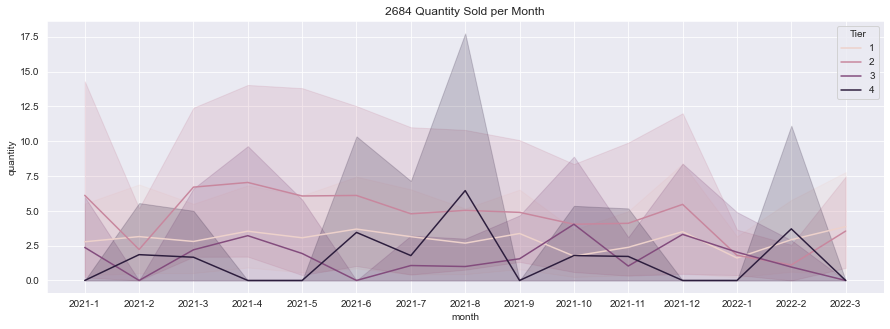

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))

fam = 2684
sns.lineplot(
    data=data[data.ProductFamilyID == fam].sort_values('date', ascending=True),
    x='month',
    y='quantity',
    hue='Tier',
    ax=ax
)

ax.set_title('{} Quantity Sold per Month'.format(fam))
plt.show()

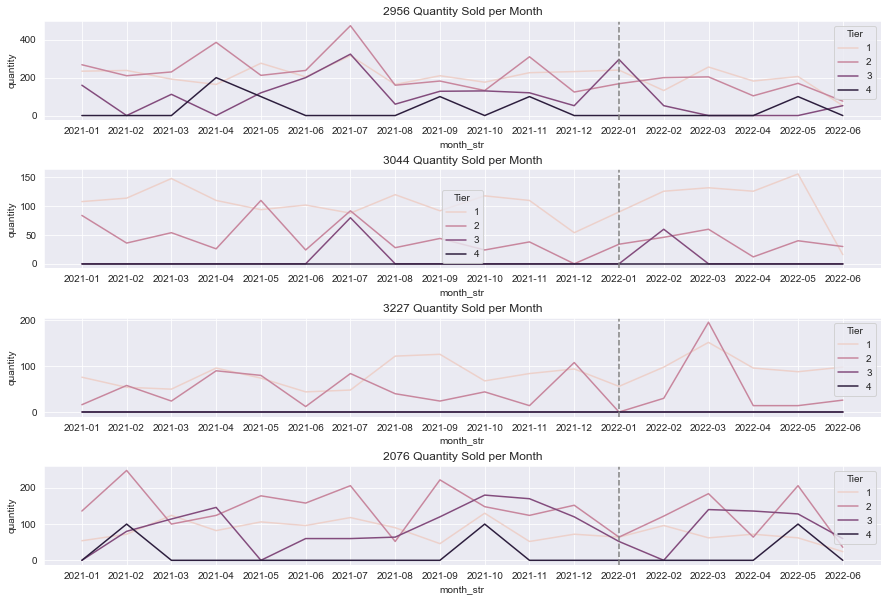

In [47]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle("QQ-Plots Test v Control", fontsize=18, y=0.95)

for n, fam in enumerate(fams):
    
    ax = plt.subplot(4, 1, n + 1)
    sns.lineplot(
        data=data[data.ProductFamilyID == fam]\
            .sort_values('date', ascending=True)\
            .groupby(['month_str', 'Tier'], as_index=False).sum('quantity'),
        x='month_str',
        y='quantity',
        hue='Tier',
        ax=ax
    )
    
    # vertical line
    ax.axvline(x=12, color='grey', linestyle='--')
    ax.set_title('{} Quantity Sold per Month'.format(fam))
    
plt.show()

In [82]:
data_ = data.groupby(['month', 'is_2022', 'treated', 'Tier', 'ProductFamilyID'], as_index=False)['quantity'].sum().copy()
data_ = data_\
    .reset_index()\
    .drop_duplicates().pivot_table(index='month', columns='ProductFamilyID', values='quantity', aggfunc='sum')\
    .sort_index()\
     .diff()\
     .dropna()\

np.array(
    data_[fams].mean(axis=1),
    data_[ctrl].mean(axis=1)
)


array([  18.5,  -15.5,   69. ,  -18.5,  -53. ,  188. , -247.5,   98.5,
        -11. ,   24.5,  -85. ,   14. ,  -25.5,  106. , -145. ,  116. ,
       -200. ])

In [87]:
data_[fams]

ProductFamilyID   2956   3044   3227   2076
month                                      
2021-02         -214.0  -42.0   20.0  310.0
2021-03           86.0   52.0  -38.0 -162.0
2021-04          216.0  -66.0  112.0   14.0
2021-05          -42.0   68.0  -32.0  -68.0
2021-06          -66.0  -78.0  -98.0   30.0
2021-07          472.0  134.0   76.0   70.0
2021-08         -730.0 -112.0   30.0 -178.0
2021-09          236.0  -12.0  -12.0  182.0
2021-10         -182.0    6.0  -38.0  170.0
2021-11          318.0    6.0  -14.0 -212.0
2021-12         -348.0  -94.0  104.0   -2.0
2022-01          296.0   70.0 -146.0 -164.0
2022-02         -320.0  108.0   72.0   38.0
2022-03           76.0  -40.0  220.0  168.0
2022-04         -174.0  -54.0 -238.0 -114.0
2022-05          190.0   58.0   -8.0  224.0
2022-06         -296.0 -150.0   22.0 -376.0

Ttest_indResult(statistic=0.15329523950898435, pvalue=0.8791280657514726)
[[1.         0.47925159]
 [0.47925159 1.        ]]
Ttest_1sampResult(statistic=array([-0.30280212, -0.28668503, -0.00605289, -0.20459419]), pvalue=array([0.76594196, 0.77803266, 0.99524535, 0.84046913]))
Ttest_1sampResult(statistic=array([-0.60233863, -0.21659744, -0.17380548, -0.18254112]), pvalue=array([0.55538983, 0.83125962, 0.86419833, 0.85745095]))
YoY Test: -316.0
YoY Ctrl: -522.0


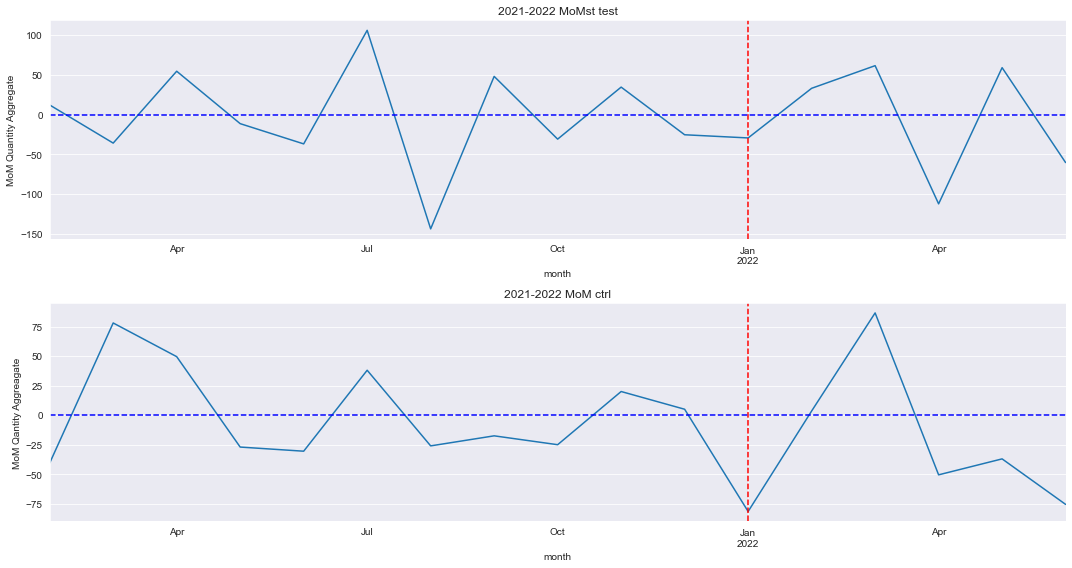

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

data_ = data[data.Tier == 2].groupby(['month', 'is_2022', 'treated', 'Tier', 'ProductFamilyID'], as_index=False)['quantity'].sum().copy()
data_ = data_\
    .reset_index()\
    .drop_duplicates().pivot_table(index='month', columns='ProductFamilyID', values='quantity', aggfunc='sum')\
    .sort_index()\
     .diff()\
     .dropna()\

data_[fams].mean(axis=1).plot(ax=ax[0])
data_[ctrl].mean(axis=1).plot(ax=ax[1])

ax[0].set_title('2021-2022 MoMst test')
ax[1].set_title('2021-2022 MoM ctrl')

# 2-samp t-test
print(
    stats.ttest_ind(
        data_[fams].sum(axis=1),
        data_[ctrl].sum(axis=1)
    )
)

# print correlation
print(
    np.corrcoef(data_[fams].mean(axis=1),
        data_[ctrl].mean(axis=1))
)

# horizontal lines at y = 0
ax[0].axvline(x=data_.index[11], color='r', linestyle='--')
ax[1].axvline(x=data_.index[11], color='r', linestyle='--')

# add vertical line at new year
ax[0].axhline(y=0, color='b', linestyle='--')
ax[1].axhline(y=0, color='b', linestyle='--')


# labels
ax[0].set_ylabel('MoM Quantity Aggregate')
ax[1].set_ylabel('MoM Qantity Aggreagate')

# one-sapmle t-test, TEST MoM different from 0?
print(
    stats.ttest_1samp(
        data_[fams].values, popmean=0
    )
)

# one-sapmle t-test, CTRL MoM different from 0?
print(
    stats.ttest_1samp(
        data_[ctrl].values, popmean=0
    )
)

print(
    'YoY Test:',
    data_[fams].sum(axis=1).sum()
)

print(
    'YoY Ctrl:',
    data_[ctrl].sum(axis=1).sum()
)

plt.tight_layout()
plt.show()

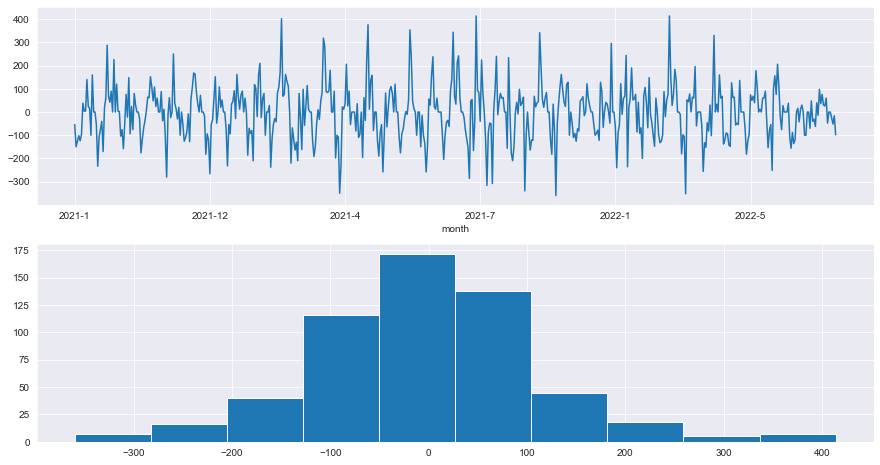

Ttest_1sampResult(statistic=-0.4420698151211786, pvalue=0.6586084462626447)

In [6]:
data_ = data.groupby(['month', 'is_2022', 'treated', 'Tier', 'ProductFamilyID'], as_index=False)['quantity'].sum().copy()

data_ = data_.set_index('month')
x = (data_.quantity - data_.quantity.shift(12)).dropna()

fig, ax = plt.subplots(2, 1, figsize=(15, 8))

# plot
x.plot(ax=ax[0])
x.hist(ax=ax[1])

plt.show()

# 1 sample t-test
stats.ttest_1samp(
    x, popmean=0
)

In [152]:
# difference in monthly
for i in np.arange(len(fams)):
    data_ = data.groupby(['month', 'is_2022', 'treated', 'Tier', 'ProductFamilyID'], as_index=False)['quantity'].sum().copy()

    print(
        stats.ttest_ind(
            data_.loc[
                (data_.is_2022 == 1) &
                (data_.Tier == 2) &
                (data_.ProductFamilyID == fams[i]), 
                'quantity'
            ],
            data_.loc[
                (data_.is_2022 == 0) &
                (data_.Tier == 2) &
                (data_.ProductFamilyID == fams[i]), 
                'quantity'
            ],
        )
    )

Ttest_indResult(statistic=-1.98613454453885, pvalue=0.06442574822083899)
Ttest_indResult(statistic=-0.6784495861669603, pvalue=0.5071814983180364)
Ttest_indResult(statistic=-0.1136429586774788, pvalue=0.9109345915477606)
Ttest_indResult(statistic=-1.388163589587098, pvalue=0.18411405501185246)


### Difference-in-Differences

In [131]:
# OLS DD
data_ = data.groupby(['month', 'is_2022', 'treated', 'Tier', 'ProductFamilyID'], as_index=False)['quantity'].sum().copy()
for i in np.arange(len(fams)):
    print(fams[i])
    print(
        smf.ols('quantity ~ is_2022*treated', 
                data=data_[
                    (data_.Tier == 2) &
                    (
                        (data_.ProductFamilyID == fams[i]) |
                        (data_.ProductFamilyID == ctrl[i])
                    )
                    
                ].dropna()).fit().summary().tables[1]
    )

2956
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         297.3333     26.521     11.211      0.000     243.311     351.355
is_2022          -160.3333     45.936     -3.490      0.001    -253.902     -66.765
treated           -53.5000     37.507     -1.426      0.163    -129.899      22.899
is_2022:treated    70.1667     64.963      1.080      0.288     -62.159     202.493
3044
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          83.8333     11.975      7.001      0.000      59.441     108.226
is_2022           -33.8333     20.742     -1.631      0.113     -76.083       8.416
treated           -37.1667     16.936     -2.195      0.036     -71.663      -2.670
is_2022:treated    24.1667     29.333      0.824      0.416     -3

In [193]:
# OLS DD
data_ = data.groupby(['month', 'is_2022', 'treated', 'Tier', 'ProductFamilyID'], as_index=False)['revenue'].sum().copy()
for i in np.arange(len(fams)):avg
    print(fams[i])
    print(
        smf.ols('revenue ~ is_2022*treated', 
                data=data_[
                    (data_.Tier == 2) &
                    (
                        (data_.ProductFamilyID == fams[i]) |
                        (data_.ProductFamilyID == ctrl[i])
                    )
                    
                ].dropna()).fit().summary().tables[1]
    )

2956
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.248e+04   2214.556     10.151      0.000     1.8e+04     2.7e+04
is_2022         -1.054e+04   3835.724     -2.748      0.010   -1.84e+04   -2727.743
treated         -3017.2583   3131.855     -0.963      0.343   -9396.639    3362.122
is_2022:treated  4329.6150   5424.532      0.798      0.431   -6719.796    1.54e+04
3044
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.987e+04   4376.465      4.540      0.000     1.1e+04    2.88e+04
is_2022         -7938.8667   7580.260     -1.047      0.303   -2.34e+04    7501.618
treated         -1.036e+04   6189.256     -1.674      0.104    -2.3e+04    2247.570
is_2022:treated  7498.2333   1.07e+04      0.699      0.489   -1.4

#### OLS difference-in-differences quantity sold
In a given order, are customers purchasing more or less?

In [5]:
# discount is 20% unless otherwise specified
data['discount'] = 0.2
data.loc[
    (data.treated == 1) &
    (data.is_2022 == 0),
    'discount'
] = 0.2

disc_2022 = [0.1, .125, .125, .15]
for i in np.arange(len(fams)):
    data.loc[
        (data.treated == 1) &
        (data.is_2022 == 1) &
        (data.ProductFamilyID == fams[i]),
        'discount'
    ] = disc_2022[i]
    

data['avg_qty'] = (data.quantity/data.orders).fillna(0)
data.head()

date  ProductFamilyID  Tier  profit  revenue  orders  customers  \
39840 2021-12-06             3403     1     0.0      0.0       0          0   
39842 2021-02-14             3403     1     0.0      0.0       0          0   
39843 2021-08-02             3403     1     0.0      0.0       0          0   
39846 2021-12-23             3403     1     0.0      0.0       0          0   
39849 2021-11-30             3403     1   806.2   1442.5       2          0   

       quantity  customers_all_tiers           tested_through    month  year  \
39840         0                    0  2022-06-13 16:41:51.870  2021-12  2021   
39842         0                    0  2022-06-13 16:41:51.870  2021-02  2021   
39843         0                    0  2022-06-13 16:41:51.870  2021-08  2021   
39846         0                    0  2022-06-13 16:41:51.870  2021-12  2021   
39849         6                    0  2022-06-13 16:41:51.870  2021-11  2021   

      month_str  avg_qty  is_2022  treated  discount  
39840   2021-12      0.0        0        0       0.2  
39842   2021-02      0.0        0        0       0.2  
39843   2021-08      0.0        0        0       0.2  
39846   2021-12      0.0        0        0       0.2  
39849   2021-11      3.0        0        0       0.2

###
Pairplot for metrics of interest.

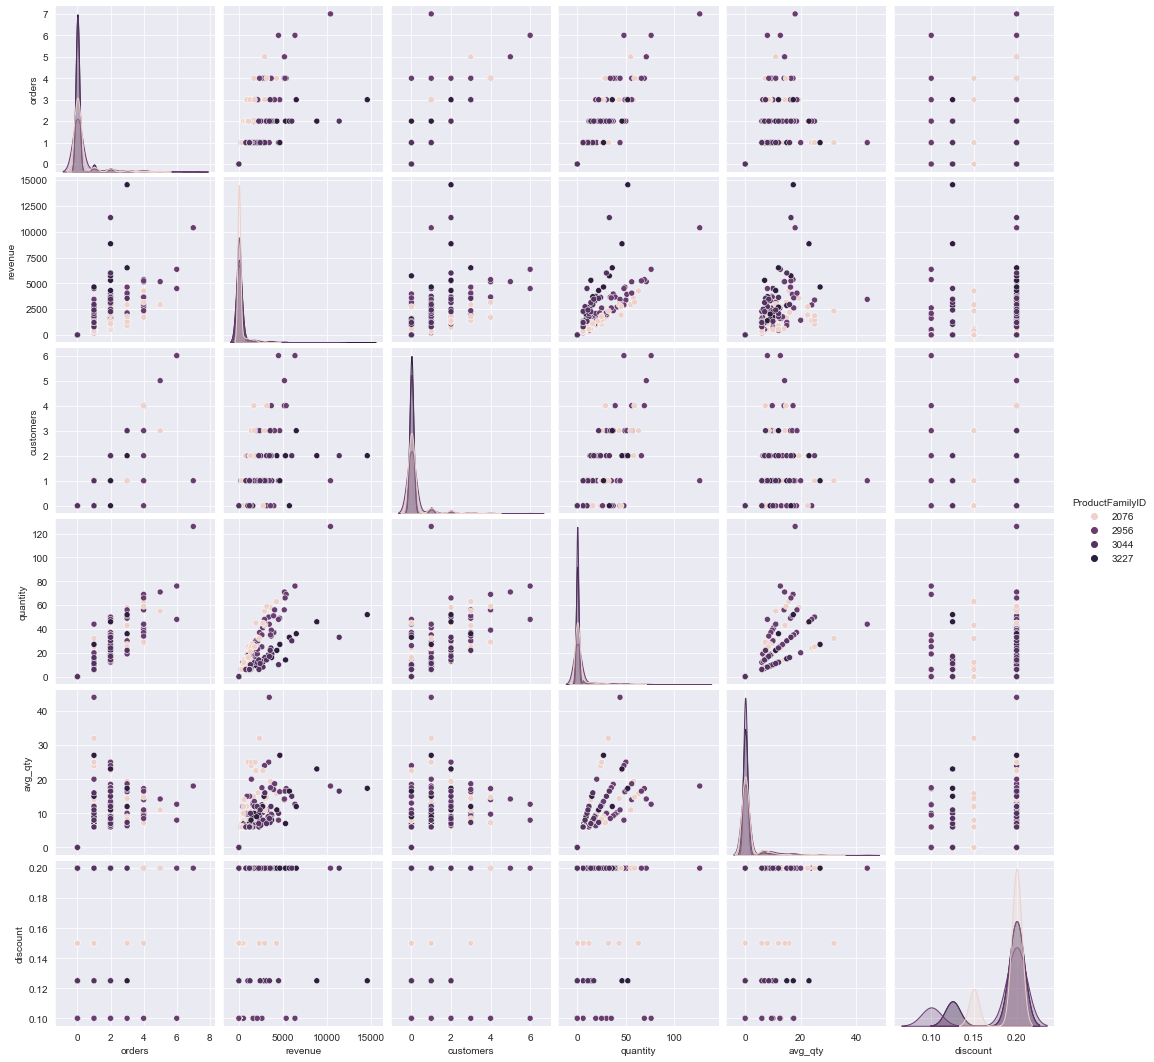

In [230]:
sns.pairplot(data=data.loc[
    (data.ProductFamilyID.isin(fams)) &
    (data.Tier == 2), 
    ['orders', 'revenue', 'customers', 'quantity', 'ProductFamilyID', 'avg_qty', 'discount']
], hue='ProductFamilyID')

plt.show()

# 
Plot tier 2 orders

ValueError: The following variable cannot be assigned with wide-form data: `hue`

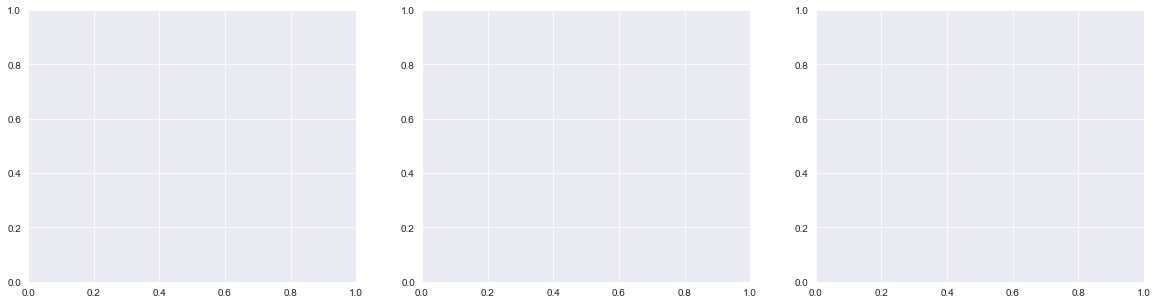

In [175]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# line plot of order value counts 
for i, metric in enumerate(['orders', 'customers', 'avg_qty']):
    sns.lineplot(
        data=data.loc[
            (data.Tier == 2) &
            (data.ProductFamilyID.isin(fams)),
            '{}'.format(metric)
        ].value_counts().sort_index().iloc[1:],
        hue='ProductFamilyID',
        ax=ax[i]
    )
    
    # labels
    ax[i].set_title('Tier 2 {} by Day'.format(metric.capitalize()))
    ax[i].set_ylabel('Days')
    ax[i].set_xlabel('{}'.format(metric.capitalize()))

# fix x ticks
ax[0].set_xticks([i for i in range(9)])

plt.show()

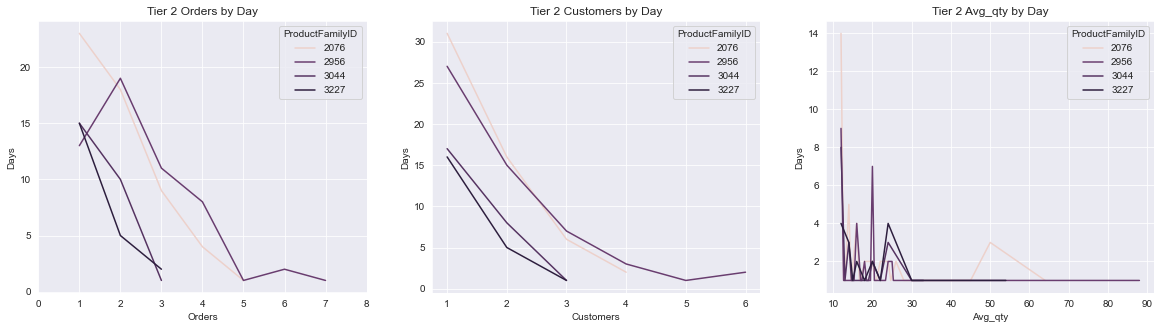

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# line plot of order value counts 
for i, metric in enumerate(['orders', 'customers', 'avg_qty']):
    x = data[
        (data.Tier == 2) &
        (data.orders != 0) & 
        (data.customers != 0) &
        (data.ProductFamilyID.isin(fams))
    ].groupby(['ProductFamilyID', '{}'.format(metric)], as_index=True)['treated'].count().reset_index().copy()
    
    x.rename(columns={'treated':'Days'}, inplace=True)
    
    sns.lineplot(
        data=x,
        hue='ProductFamilyID',
        y='Days',
        x='{}'.format(metric),
        ax=ax[i]
    )
    
    # labels
    ax[i].set_title('Tier 2 {} by Day'.format(metric.capitalize()))
    ax[i].set_ylabel('Days')
    ax[i].set_xlabel('{}'.format(metric.capitalize()))

# fix x ticks
ax[0].set_xticks([i for i in range(9)])

plt.show()

In [14]:
x.sort_values('Days', ascending=False).head(10)

ProductFamilyID  avg_qty  Days
0              2076     12.0    14
28             2956     12.0     9
63             3044     12.0     8
42             2956     20.0     7
3              2076     14.0     5
6              2076     16.0     4
84             3227     24.0     4
34             2956     16.0     4
77             3227     12.0     4
78             3227     14.0     3

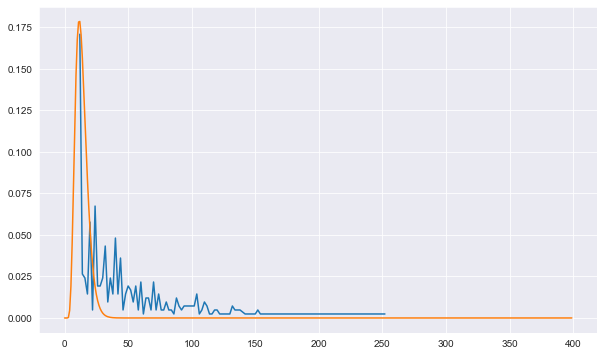

In [95]:
# choose a prior for the data
poiss = data.loc[
    (data.Tier == 2),
    'quantity'
].value_counts().sort_index().iloc[1:]

# Poisson liklihood
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(0, 200, 400)

# check prior
(poiss/poiss.sum()).plot(ax=ax)
ax.plot(stats.gamma.pdf(x, poiss.mean(), 1))
plt.show()

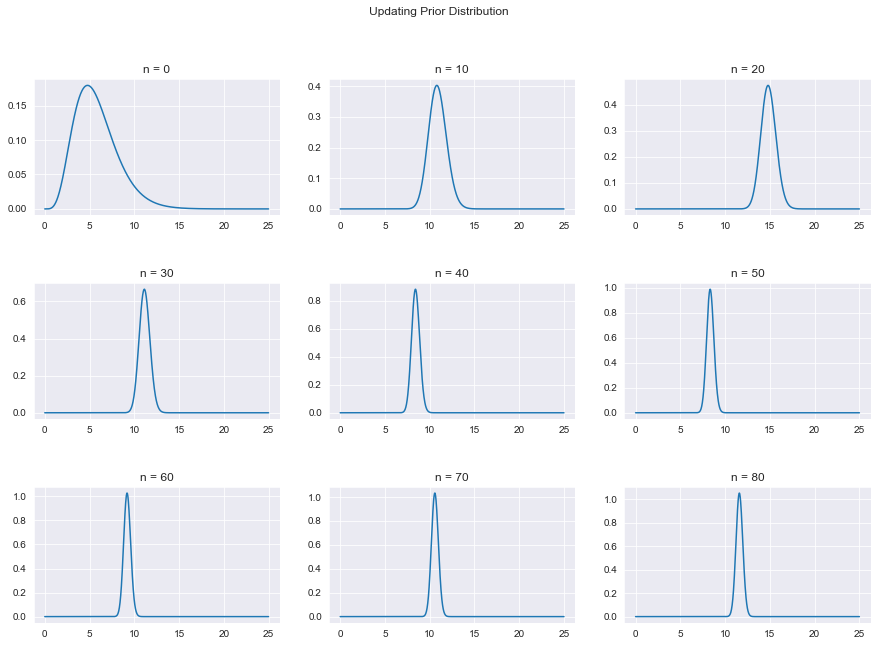

In [34]:
# built figure
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# get data
b = data.loc[
    (data.Tier == 2),
    'quantity'
].copy()

# plot prior updating
i = 0
x = np.linspace(0, 25, 1000)
for n in np.arange(9):
    n = 10*n
    
    ax = plt.subplot(3, 3, i+1)
    plt.plot(x, stats.gamma.pdf(x, poiss.mean() + b.iloc[:n].sum(), scale = 1/(1 + n)))
    
    ax.set_title('n = {}'.format(str(n)))
    i += 1
    
# title and show
plt.suptitle('Updating Prior Distribution')
plt.show()

https://cran.r-project.org/web/packages/bayesAB/vignettes/introduction.html

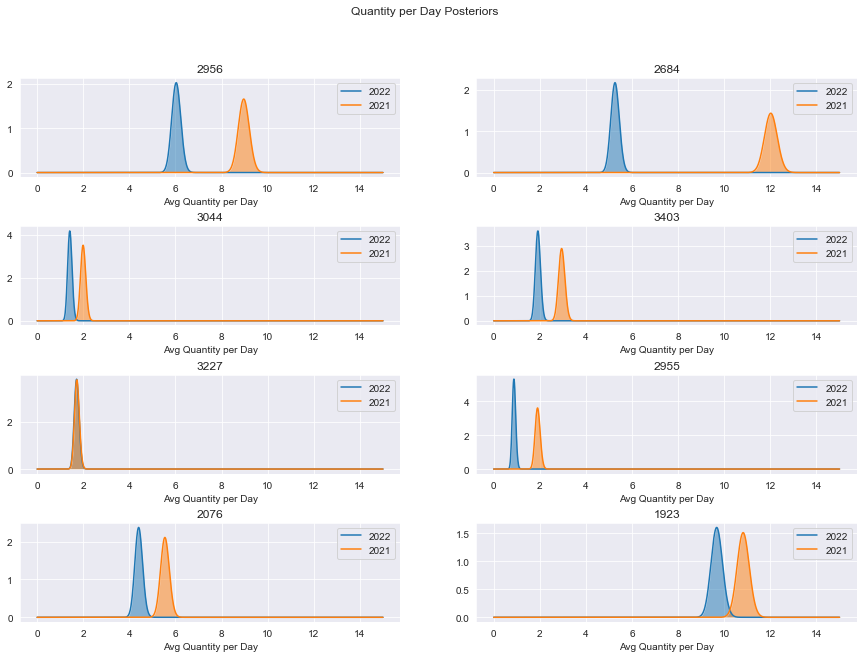

In [193]:
# compute posteriors for pre and post periods
# choose a prior for the data
# built figure
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# prior 
x = np.linspace(0, 15, 1000)
prior = stats.gamma.pdf(x, poiss.mean(), 1)

i = 0
for j in range(len(fams)):
    fam = fams[j]
    ctr = ctrl[j]
    
    # compare against YTD 2021
    today = data.date.max()
    today_last_year = today - pd.Timedelta(365, "day")
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    
    ax = plt.subplot(4, 2, i+1)
    
    post2021 = stats.gamma.pdf(x, b[b.date.dt.year != 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year != 2022)))
    post2022 = stats.gamma.pdf(x, b[b.date.dt.year == 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year == 2022)))
    
    ax.plot(x, post2022)
    ax.plot(x, post2021)
    
    # fill under the curve
    ax.fill_between(x, post2022, alpha=0.5)
    ax.fill_between(x, post2021, alpha=0.5)
    
    # set labels
    ax.set_title('{}'.format(str(fam)))
    ax.set_xlabel('Avg Quantity per Day')
    ax.legend(['2022', '2021'])
    
    i += 1
    
    ax = plt.subplot(4, 2, i+1)
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == ctr) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    post2021 = stats.gamma.pdf(x, b[b.date.dt.year != 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year != 2022)))
    post2022 = stats.gamma.pdf(x, b[b.date.dt.year == 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year == 2022)))
    
    ax.plot(x, post2022)
    ax.plot(x, post2021)
    
    # fill under the curve
    ax.fill_between(x, post2022, alpha=0.5)
    ax.fill_between(x, post2021, alpha=0.5)
    
    # set labels
    ax.set_title('{}'.format(str(ctr)))
    ax.set_xlabel('Avg Quantity per Day')
    ax.legend(['2022', '2021'])
    
    i += 1
    
# plt.plot(x, stats.gamma.pdf(x, b.quantity.sum(), scale = 1/( len(b))))
plt.suptitle('Quantity per Day Posteriors')

plt.show()

In [100]:
data.month.dt.year

39840      2021
39842      2021
39843      2021
39846      2021
39849      2021
           ... 
1517227    2022
1517231    2021
1517232    2021
1517233    2021
1517235    2021
Name: month, Length: 15872, dtype: int64

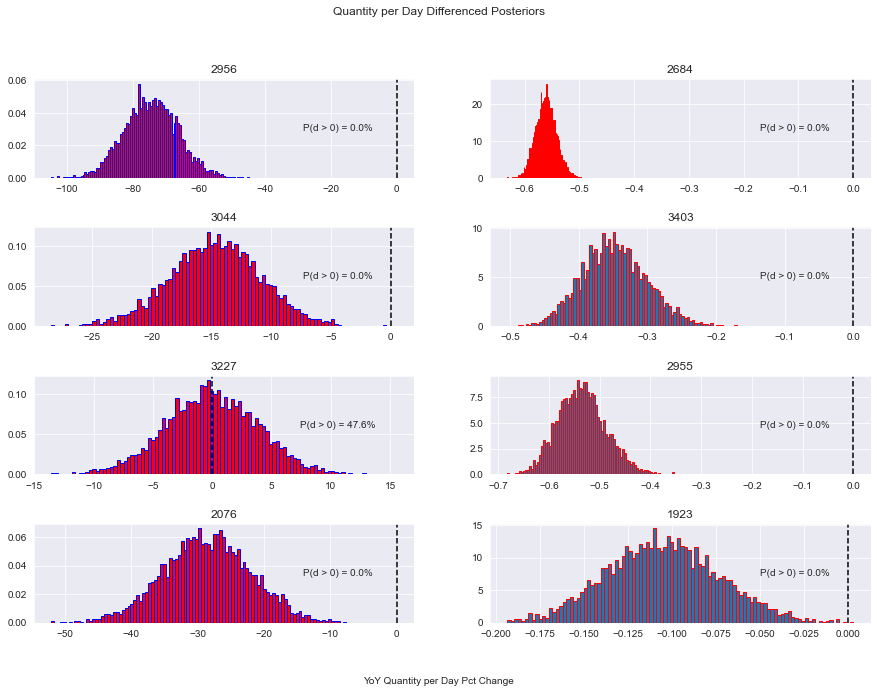

In [101]:
# compute posteriors for pre and post periods
# choose a prior for the data
# built figure
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# group by month
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier'], as_index=False)['quantity'].sum()

# prior 
x = np.linspace(0, 15, 1000)
prior = stats.gamma.pdf(x, poiss.mean(), 1)

i = 0
for j in range(len(fams)):
    fam = fams[j]
    ctr = ctrl[j]
    
    # compare against YTD 2021
    today = data.date.max()
    today_last_year = today - pd.Timedelta(365, "day")
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    b = b.groupby(['month', 'ProductFamilyID', 'Tier'], as_index=False)['quantity'].sum()
    
    ax = plt.subplot(4, 2, i+1)
    ax.axvline(0, linestyle='--', color='black')
    
    size = 5000
    nbin=100
    post2021 = stats.gamma.rvs(6 + b[b.month.dt.year != 2022].quantity.sum(), scale = 1/(sum(b.month.dt.year != 2022)), size=size)
    post2022 = stats.gamma.rvs(6 + b[b.month.dt.year == 2022].quantity.sum(), scale = 1/(sum(b.month.dt.year == 2022)), size=size)
    
#     post2021 = stats.norm.rvs(b[b.date.dt.year != 2022].quantity.mean(), b[b.date.dt.year != 2022].quantity.std(), size=size)
#     post2022 = stats.norm.rvs(b[b.date.dt.year == 2022].quantity.mean(), b[b.date.dt.year != 2022].quantity.std(), size=size)
    
    # get 2021 vs 2022 difference 
    d = (post2022 - post2021)#/post2021
    
    # P(d > 0)
    hist, bin_edges = np.histogram(d, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(d > 0) = ' + str(np.round(100*p, 1)) + '%'

    plt.hist(d, density=True, color='r', bins=nbin, ec='blue')
    
    ax.text(0.8, 0.5, sig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(fam))) 
    i += 1
    
    ax = plt.subplot(4, 2, i+1)
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == ctr) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    post2021 = stats.gamma.rvs(b[b.date.dt.year != 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022 = stats.gamma.rvs(b[b.date.dt.year == 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)
    
    # get 2021 vs 2022 difference P(d > 0)
    d = (post2022 - post2021)/post2021
   
     # P(d > 0)
    hist, bin_edges = np.histogram(d, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(d > 0) = ' + str(np.round(100*p, 1)) + '%'

    ax.hist(d, density=True, bins=nbin, ec="r")
    ax.axvline(0, linestyle='--', color='black')
    
    ax.text(0.8, 0.5, sig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(ctr)))
    
    i += 1
    
fig.text(0.5, 0.04, 'YoY Quantity per Day Pct Change', ha='center')
plt.suptitle('Quantity per Day Differenced Posteriors')
plt.show()

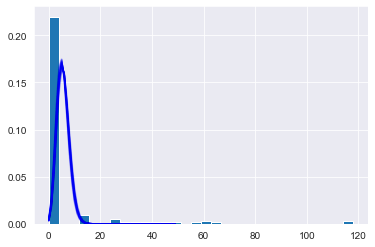

In [349]:
b = data[
    (data.Tier == 2) &
    (data.ProductFamilyID == fam) &
    (
        (data.year == 2022) | 
        (data.date <= today_last_year)
    )
].copy()#.groupby(['month', 'year'], as_index=False).quantity.sum().copy()

post2021 = stats.gamma.rvs(b[b.year != 2022].quantity.sum(), scale = 1/(sum(b.year != 2022)), size=size)
post2022 = stats.gamma.rvs(b[b.year == 2022].quantity.sum(), scale = 1/(sum(b.year == 2022)), size=size)

l = np.arange(0, 50)
for i in range(100):
    plt.plot(l, stats.poisson.pmf(l, post2021[i]), color='blue', alpha=0.05)
    
plt.hist(b[b.year != 2022].quantity, density=True, bins=30)

plt.show()

In [355]:
for yr in [2021, 2022]: 
    print(b[b.year == yr][['quantity', 'customers', 'orders']].value_counts())

quantity  customers  orders
0         0          0         134
12        1          1           4
24        2          2           2
44        2          2           1
116       2          3           1
64        2          2           1
62        1          3           1
60        2          2           1
58        4          4           1
50        3          3           1
42        2          2           1
12        0          1           1
38        2          3           1
32        2          2           1
28        2          2           1
26        1          2           1
14        1          1           1
118       4          4           1
dtype: int64
quantity  customers  orders
0         0          0         139
12        1          1           2
26        1          1           2
14        1          1           1
16        1          1           1
20        0          1           1
24        1          1           1
                     2           1
          2          

(array([133.,   2.,   4.,   7.,   2.,   3.,   2.,   0.,   0.,   2.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <BarContainer object of 10 artists>)

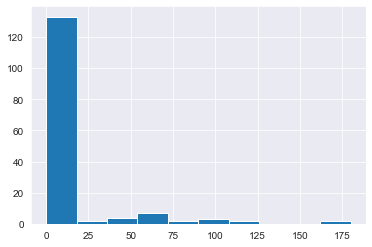

In [237]:
plt.hist(b.loc[b.date.dt.year != 2022, 'quantity'])
#plt.hist(post2021)

In [204]:
b = data[
    (data.Tier == 2) &
    (data.ProductFamilyID == 1923) &
    (
        (data.date.dt.year == 2022) | 
        (data.date <= today_last_year)
    )
].copy()

b.groupby('is_2022').avg_qty.mean()#.diff()

is_2022
0    2.973671
1    2.986396
Name: avg_qty, dtype: float64

In [205]:
t = data[
        (data.Tier == 2) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
].copy()
            
t = t.groupby(['ProductFamilyID', 'is_2022', 'treated'], as_index=False)['quantity'].mean()
t

ProductFamilyID  is_2022  treated   quantity
0              1923        0        0  10.825806
1              1923        1        0   9.679487
2              2076        0        1   5.548387
3              2076        1        1   4.410256
4              2684        0        0  12.025806
5              2684        1        0   5.269231
6              2955        0        0   1.909677
7              2955        1        0   0.884615
8              2956        0        1   8.967742
9              2956        1        1   6.038462
10             3044        0        1   2.000000
11             3044        1        1   1.423077
12             3227        0        1   1.729032
13             3227        1        1   1.717949
14             3403        0        0   2.954839
15             3403        1        0   1.923077

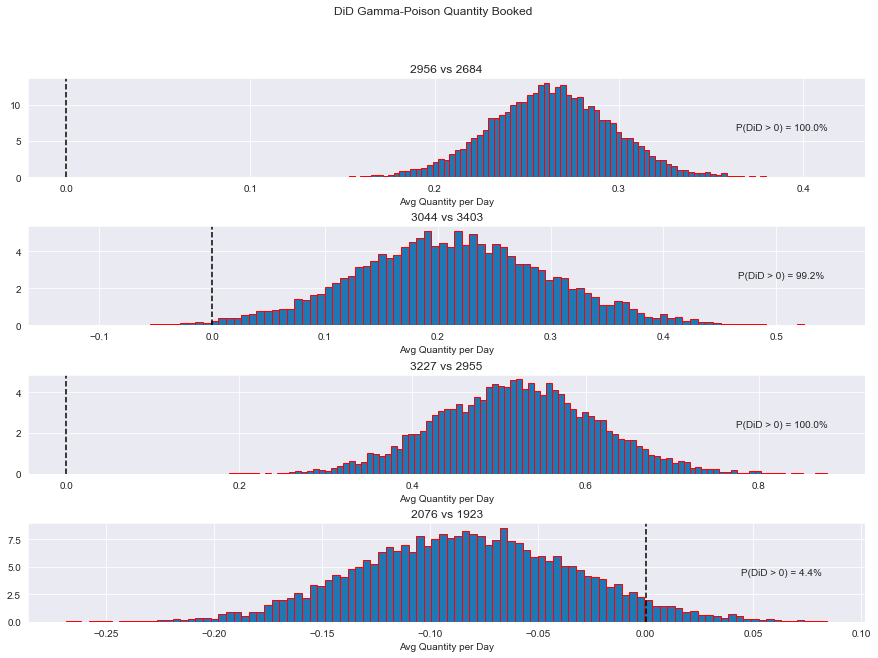

In [43]:
# compute posteriors for pre and post periods
# choose a prior for the data
# built figure
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# prior 
x = np.linspace(0, 15, 1000)
prior = stats.gamma.pdf(x, poiss.mean(), 1)

i = 0
for j in range(len(fams)):
    fam = fams[j]
    ctr = ctrl[j]
    
    # posterior
    a = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam)
    ].copy()
    
    # compare against YTD 2021
    today = data.date.max()
    today_last_year = today - pd.Timedelta(365, "day")
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == ctr) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    # create subplot
    ax = plt.subplot(4, 1, i+1)
    
    # sample from posteriors
    size = 10000
    nbin=100
    
    post2021_test = stats.gamma.rvs(a[a.date.dt.year == 2021].quantity.sum(), scale = 1/(sum(a.date.dt.year != 2022)), size=size)
    post2022_test = stats.gamma.rvs(a[a.date.dt.year == 2022].quantity.sum(), scale = 1/(sum(a.date.dt.year == 2022)), size=size)
    
    post2021_ctrl = stats.gamma.rvs(b[b.date.dt.year == 2021].quantity.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022_ctrl = stats.gamma.rvs(b[b.date.dt.year == 2022].quantity.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)

    #DiD
    d2 = (post2022_test - post2021_test)/post2021_test
    d1 = (post2022_ctrl - post2021_ctrl)/post2021_ctrl

    hist1 = stats.rv_histogram(np.histogram(d1)).rvs(size=size)
    hist2 = stats.rv_histogram(np.histogram(d2)).rvs(size=size)
                               
    hist = hist2 - hist1
                               
    # plot                          
    ax.hist(hist, density=True, bins=nbin, ec="r")
    ax.axvline(0, linestyle='--', color='black')
    
    # P(DiD > 0)
    hist, bin_edges = np.histogram(hist, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(DiD > 0) = ' + str(np.round(100*p, 1)) + '%'
    
    # text P(DiD > 0)
    ax.text(0.9, 0.5, sig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(fam)) + ' vs ' + '{}'.format(str(ctr)))
    ax.set_xlabel('Avg Quantity per Day')
    
    i += 1
    
plt.suptitle('DiD Gamma-Poison Quantity Booked')
plt.show()

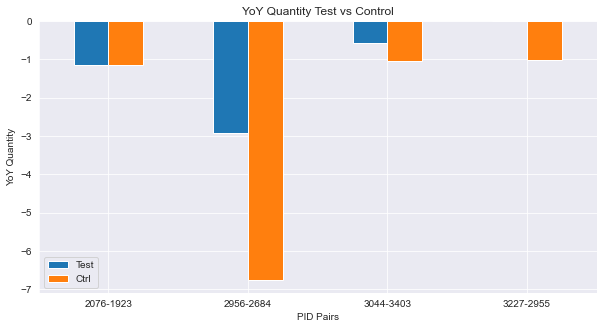

ProductFamilyID_x treated_x  yoy_qty_x  test  ctrl  \
2076-1923              2076         1  -1.138131  2076  1923   
2956-2684              2956         1  -2.929280  2956  2684   
3044-3403              3044         1  -0.576923  3044  3403   
3227-2955              3227         1  -0.011084  3227  2955   

          ProductFamilyID_y treated_y  yoy_qty_y  
2076-1923              1923         0  -1.146319  
2956-2684              2684         0  -6.756576  
3044-3403              3403         0  -1.031762  
3227-2955              2955         0  -1.025062

In [336]:
# get YoY difference in test and ctrl groups and compare
t = data[
        (data.Tier == 2) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
].copy()
            
t = t.groupby(['ProductFamilyID', 'is_2022', 'treated'], as_index=False)['quantity'].mean()
t_ = t.groupby(['ProductFamilyID', 'treated'], as_index=False).quantity.mean()[['ProductFamilyID', 'treated']].drop_duplicates().astype(str)
t_['yoy_qty'] = t.groupby(['ProductFamilyID', 'treated'], as_index=True).quantity.diff().dropna().values

a = t_[t_.ProductFamilyID.isin([str(f) for f in fams])]
b = t_[t_.ProductFamilyID.isin([str(f) for f in ctrl])]

# build join table
join_table = pd.DataFrame(np.array([fams, ctrl])).T.astype(str)
join_table.columns = ['test', 'ctrl']

# merge tables
t_ = a.merge(join_table, left_on='ProductFamilyID', right_on='test')\
    .merge(b, left_on='ctrl', right_on='ProductFamilyID')

t_.index = t_.ProductFamilyID_x + '-' + t_.ProductFamilyID_y

# plot
fig, ax = plt.subplots(figsize=(10, 5))
t_[['yoy_qty_x', 'yoy_qty_y']].plot.bar(rot=0, ax=ax)


# labels
ax.set_title('YoY Quantity Test vs Control')
ax.set_ylabel('YoY Quantity')
ax.set_xlabel('PID Pairs')
plt.legend(['Test', 'Ctrl'])

plt.show()

t_

# Revenue DiD

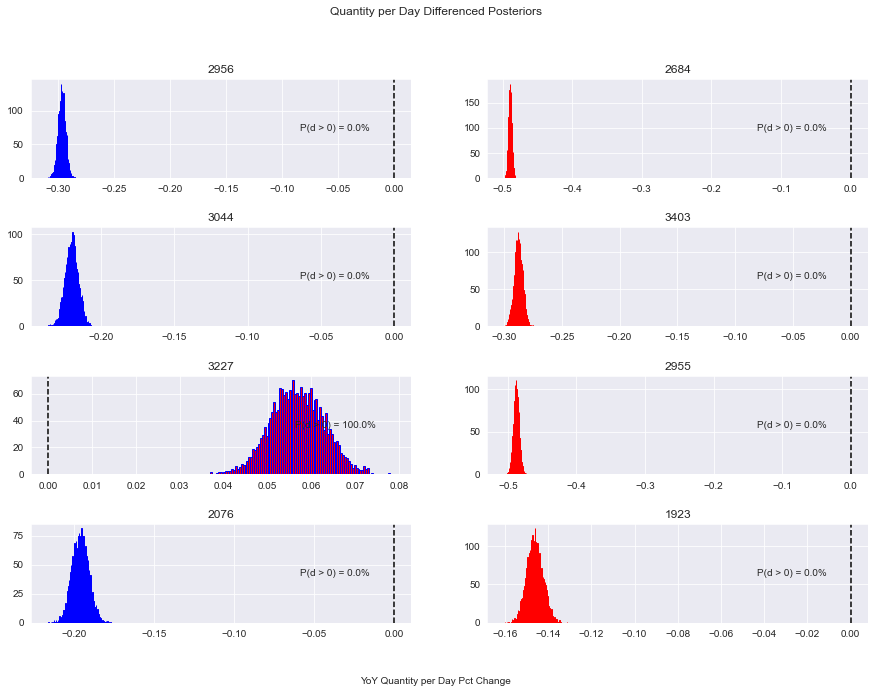

In [366]:
# compute posteriors for pre and post periods
# choose a prior for the data
# built figure
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# prior 
x = np.linspace(0, 15, 1000)
prior = stats.gamma.pdf(x, poiss.mean(), 1)

i = 0
for j in range(len(fams)):
    fam = fams[j]
    ctr = ctrl[j]
    
    # compare against YTD 2021
    today = data.date.max()
    today_last_year = today - pd.Timedelta(365, "day")
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    ax = plt.subplot(4, 2, i+1)
    ax.axvline(0, linestyle='--', color='black')
    
    size = 5000
    nbin=100
    post2021 = stats.gamma.rvs(b[b.date.dt.year != 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022 = stats.gamma.rvs(b[b.date.dt.year == 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)
    
    # get 2021 vs 2022 difference 
    d = (post2022 - post2021)/post2021
    
    # P(d > 0)
    hist, bin_edges = np.histogram(d, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(d > 0) = ' + str(np.round(100*p, 1)) + '%'

    plt.hist(d, density=True, color='r', bins=nbin, ec='blue')
    
    ax.text(0.8, 0.5, sig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(fam))) 
    i += 1
    
    ax = plt.subplot(4, 2, i+1)
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == ctr) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    post2021 = stats.gamma.rvs(b[b.date.dt.year != 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022 = stats.gamma.rvs(b[b.date.dt.year == 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)
    
    # get 2021 vs 2022 difference P(d > 0)
    d = (post2022 - post2021)/post2021
   
     # P(d > 0)
    hist, bin_edges = np.histogram(d, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(d > 0) = ' + str(np.round(100*p, 1)) + '%'

    ax.hist(d, density=True, bins=nbin, ec="r")
    ax.axvline(0, linestyle='--', color='black')
    
    ax.text(0.8, 0.5, sig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(ctr)))
    
    i += 1
    
fig.text(0.5, 0.04, 'YoY Revenue per Day Pct Change', ha='center')
plt.suptitle('Quantity per Day Differenced Posteriors')
plt.show()

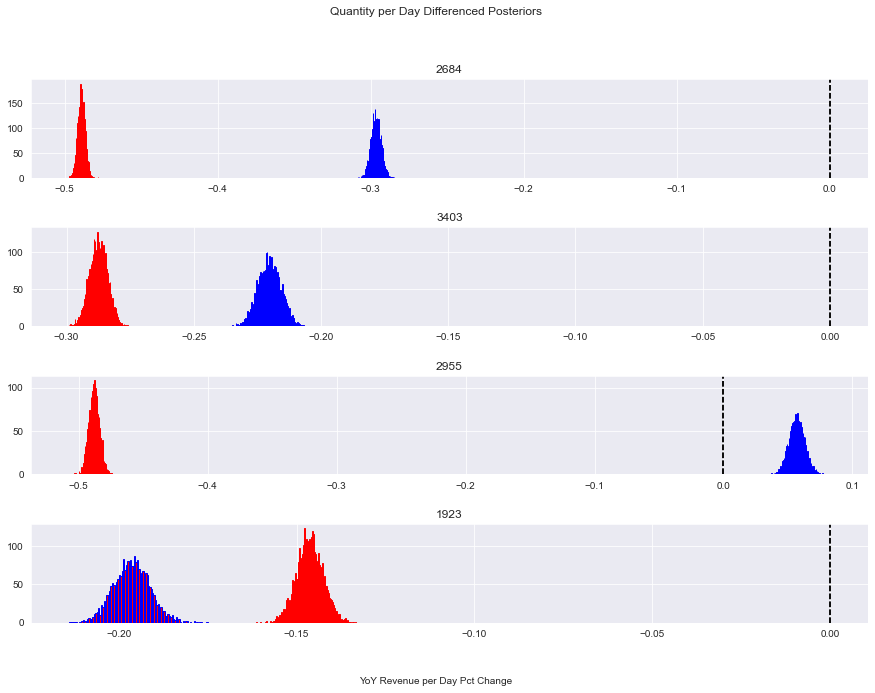

In [39]:
# compute posteriors for pre and post periods
# choose a prior for the data
# built figure
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# prior 
x = np.linspace(0, 15, 1000)
prior = stats.gamma.pdf(x, poiss.mean(), 1)

i = 0
for j in range(len(fams)):
    fam = fams[j]
    ctr = ctrl[j]
    
    # compare against YTD 2021
    today = data.date.max()
    today_last_year = today - pd.Timedelta(365, "day")
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    ax = plt.subplot(4, 1, i+1)
    ax.axvline(0, linestyle='--', color='black')
    
    size = 5000
    nbin=100
    post2021 = stats.gamma.rvs(b[b.date.dt.year != 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022 = stats.gamma.rvs(b[b.date.dt.year == 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)
    
    # get 2021 vs 2022 difference 
    d = (post2022 - post2021)/post2021
    
    # P(d > 0)
    hist, bin_edges = np.histogram(d, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(d > 0) = ' + str(np.round(100*p, 1)) + '%'

    plt.hist(d, density=True, color='r', bins=nbin, ec='blue')
    
#     ax.text(0.8, 0.5, sig, horizontalalignment='center',
#      verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(fam))) 
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == ctr) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    post2021 = stats.gamma.rvs(b[b.date.dt.year != 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022 = stats.gamma.rvs(b[b.date.dt.year == 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)
    
    # get 2021 vs 2022 difference P(d > 0)
    d = (post2022 - post2021)/post2021
   
     # P(d > 0)
    hist, bin_edges = np.histogram(d, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(d > 0) = ' + str(np.round(100*p, 1)) + '%'

    ax.hist(d, density=True, bins=nbin, ec="r")
    ax.axvline(0, linestyle='--', color='black')
    
#     ax.text(0.8, 0.5, sig, horizontalalignment='center',
#      verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(ctr)))
    
    i += 1
    
fig.text(0.5, 0.04, 'YoY Revenue per Day Pct Change', ha='center')
plt.suptitle('Quantity per Day Differenced Posteriors')
plt.show()

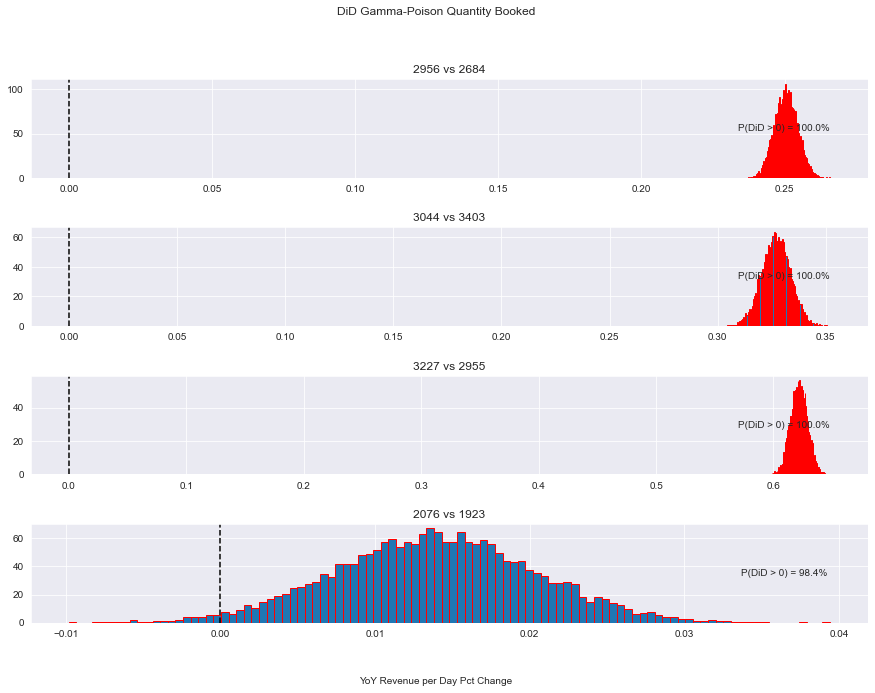

In [36]:
# compute posteriors for pre and post periods
# choose a prior for the data
# built figure
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# prior 
x = np.linspace(0, 15, 1000)
prior = stats.gamma.pdf(x, poiss.mean(), 1)

i = 0
for j in range(len(fams)):
    fam = fams[j]
    ctr = ctrl[j]
    
    # posterior
    a = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam)
    ].copy()
    
    # compare against YTD 2021
    today = data.date.max()
    today_last_year = today - pd.Timedelta(365, "day")
    
    # posterior
    b = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == ctr) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
    ].copy()
    
    # create subplot
    ax = plt.subplot(4, 1, i+1)
    
    # sample from posteriors
    size = 10000
    nbin=100
    
    post2021_test = stats.gamma.rvs(a[a.date.dt.year == 2021].revenue.sum(), scale = 1/(sum(a.date.dt.year != 2022)), size=size)
    post2022_test = stats.gamma.rvs(a[a.date.dt.year == 2022].revenue.sum(), scale = 1/(sum(a.date.dt.year == 2022)), size=size)
    
    post2021_ctrl = stats.gamma.rvs(b[b.date.dt.year == 2021].revenue.sum(), scale = 1/(sum(b.date.dt.year != 2022)), size=size)
    post2022_ctrl = stats.gamma.rvs(b[b.date.dt.year == 2022].revenue.sum(), scale = 1/(sum(b.date.dt.year == 2022)), size=size)
    
#     post2021_test = stats.norm.rvs(a[a.date.dt.year != 2022].revenue.mean(), a[a.date.dt.year != 2022].revenue.std(), size=size)
#     post2022_test = stats.norm.rvs(a[a.date.dt.year == 2022].revenue.mean(), a[a.date.dt.year != 2022].revenue.std(), size=size)
    
#     post2021_test = stats.norm.rvs(b[b.date.dt.year != 2022].revenue.mean(), b[b.date.dt.year != 2022].revenue.std(), size=size)
#     post2022_test = stats.norm.rvs(b[b.date.dt.year == 2022].revenue.mean(), b[b.date.dt.year != 2022].revenue.std(), size=size)

    d2 = (post2022_test - post2021_test)/post2021_test 
    d1 = (post2022_ctrl - post2021_ctrl)/post2021_ctrl

    hist1 = stats.rv_histogram(np.histogram(d1)).rvs(size=size)
    hist2 = stats.rv_histogram(np.histogram(d2)).rvs(size=size)
                               
    hist = hist2 - hist1
                               
    # plot                          
    ax.hist(hist, density=True, bins=nbin, ec="r")
    ax.axvline(0, linestyle='--', color='black')
    
    # P(DiD > 0)
    hist, bin_edges = np.histogram(hist, bins=nbin)
    p = hist[bin_edges[:-1] > 0].sum()/hist.sum()
    sig = 'P(DiD > 0) = ' + str(np.round(100*p, 1)) + '%'
    
    # text P(DiD > 0)
    ax.text(0.9, 0.5, sig, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    
    # set labels
    ax.set_title('{}'.format(str(fam)) + ' vs ' + '{}'.format(str(ctr)))
    
    i += 1
    
fig.text(0.5, 0.04, 'YoY Revenue per Day Pct Change', ha='center')
plt.suptitle('DiD Gamma-Poison Quantity Booked')
plt.show()

328.4570588235294 1020.2965897286774


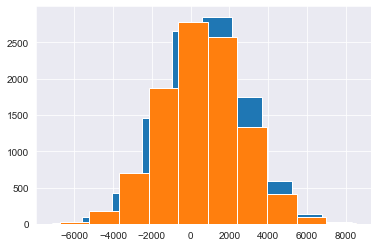

In [299]:
a = data[
        (data.Tier == 2) &
        (data.ProductFamilyID == fam)
].copy()

mu = a[a.date.dt.year != 2022].revenue.mean()
sigma = a[a.date.dt.year != 2022].revenue.std()

print(mu, sigma)

mu = a.groupby(['month', 'year']).revenue.sum().mean()
sigma = a.groupby(['month', 'year']).revenue.sum().std()


stats.norm.rvs(mu, sigma, size=size)

plt.hist(post2021_test)
plt.hist(post2022_test)

plt.show()

In [297]:
print(
    a.groupby(['month', 'year']).revenue.sum().mean(),
    a.groupby(['month', 'year']).revenue.sum().std()
)

8673.843333333332 3406.516218275861


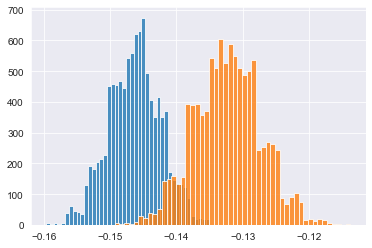

In [376]:
plt.hist(hist1, bins=50, alpha=0.8)
plt.hist(hist2, bins=50, alpha=0.8)

plt.show()

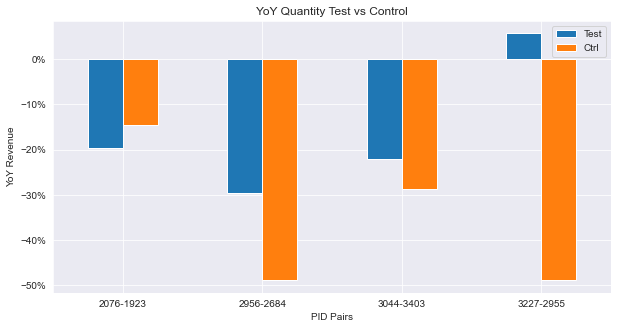

ProductFamilyID_x treated_x  yoy_qty_x  test  ctrl  \
2076-1923              2076         1 -19.638701  2076  1923   
2956-2684              2956         1 -29.670111  2956  2684   
3044-3403              3044         1 -22.043108  3044  3403   
3227-2955              3227         1   5.668468  3227  2955   

          ProductFamilyID_y treated_y  yoy_qty_y  
2076-1923              1923         0 -14.636567  
2956-2684              2684         0 -48.923406  
3044-3403              3403         0 -28.761821  
3227-2955              2955         0 -48.825350

In [349]:
# get YoY difference in test and ctrl groups and compare
t = data[
        (data.Tier == 2) &
        (
            (data.date.dt.year == 2022) | 
            (data.date <= today_last_year)
        )
].copy()
            
t = t.groupby(['ProductFamilyID', 'is_2022', 'treated'], as_index=False)['revenue'].mean()
t_ = t.groupby(['ProductFamilyID', 'treated'], as_index=False).revenue.mean()[['ProductFamilyID', 'treated']].drop_duplicates().astype(str)
t_['yoy_qty'] = t.groupby(['ProductFamilyID', 'treated'], as_index=True).revenue.pct_change().dropna().values*100

a = t_[t_.ProductFamilyID.isin([str(f) for f in fams])]
b = t_[t_.ProductFamilyID.isin([str(f) for f in ctrl])]

# build join table
join_table = pd.DataFrame(np.array([fams, ctrl])).T.astype(str)
join_table.columns = ['test', 'ctrl']

# merge tables
t_ = a.merge(join_table, left_on='ProductFamilyID', right_on='test')\
    .merge(b, left_on='ctrl', right_on='ProductFamilyID')

t_.index = t_.ProductFamilyID_x + '-' + t_.ProductFamilyID_y

# plot
fig, ax = plt.subplots(figsize=(10, 5))
t_[['yoy_qty_x', 'yoy_qty_y']].plot.bar(rot=0, ax=ax)


# labels
ax.set_title('YoY Quantity Test vs Control')
ax.set_ylabel('YoY Revenue')
ax.set_xlabel('PID Pairs')
plt.legend(['Test', 'Ctrl'])

# pct format y axis
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

t_

In [354]:
data[
    (data.Tier == 2) &
    (
        (data.date.dt.year == 2022) | 
        (data.date <= today_last_year)
    )
].groupby(['ProductFamilyID', 'is_2022'], as_index=False).revenue.mean().groupby('ProductFamilyID').revenue.diff()

0            NaN
1    -105.730596
2            NaN
3     -69.638581
4            NaN
5    -439.799326
6            NaN
7    -146.196328
8            NaN
9    -220.596129
10           NaN
11    -98.641629
12           NaN
13     21.031844
14           NaN
15   -185.278081
Name: revenue, dtype: float64

In [30]:
stats.ttest_ind(
    b.loc[b.date.dt.year != 2022, 'quantity'],
    b.loc[b.date.dt.year == 2022, 'quantity']
)

Ttest_indResult(statistic=1.0312336041852808, pvalue=0.30293897589331825)

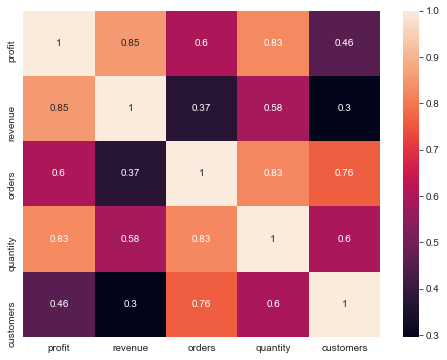

In [47]:
# correlation heatmap when there is an order
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    data=data.loc[
        (data.Tier == 2) &
        (data.orders != 0),
        ['profit', 'revenue', 'orders', 'quantity', 'customers']
    ].corr(),
    annot=True,
    ax=ax
)

plt.show()

#
Did decreasing the discount decrease demand?

Ttest_indResult(statistic=-0.9630434496500874, pvalue=0.33593480784450935)


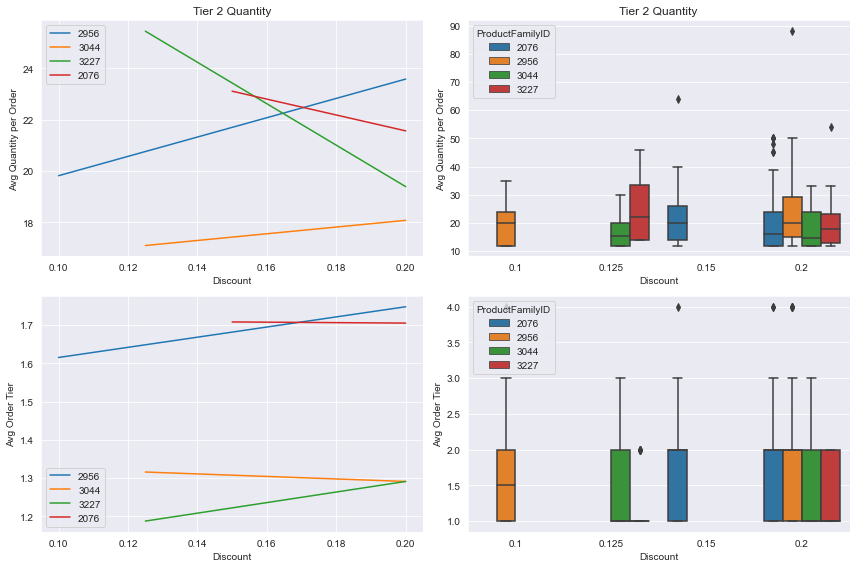

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i in np.arange(len(fams)):
    ax[0, 0].plot(data[
        (data.ProductFamilyID == fams[i]) &
        (data.Tier == 2) &
        (data.avg_qty) != 0
    ].groupby('discount')['avg_qty'].mean())
ax[0, 0].set_ylabel('Avg Quantity per Order')
ax[0, 0].set_xlabel('Discount')
ax[0, 0].set_title('Tier 2 Quantity')
ax[0, 0].legend(fams)

sns.boxplot(data=data[
    (data.ProductFamilyID.isin(fams)) & 
    (data.Tier == 2) &
    (data.avg_qty) != 0
], x='discount', y='avg_qty', hue='ProductFamilyID', ax=ax[0, 1])

ax[0, 1].set_ylabel('Avg Quantity per Order')
ax[0, 1].set_xlabel('Discount')
ax[0, 1].set_title('Tier 2 Quantity')

# tier migration
for i in np.arange(len(fams)):
    ax[1, 0].plot(data[
        (data.ProductFamilyID == fams[i]) &
        #(data.Tier == 2) &
        (data.avg_qty) != 0
    ].groupby('discount')['Tier'].mean())
ax[1, 0].set_ylabel('Avg Order Tier')
ax[1, 0].set_xlabel('Discount')
ax[1, 0].legend(fams)

sns.boxplot(data=data[
    (data.ProductFamilyID.isin(fams)) & 
    #(data.Tier == 2) &
    (data.avg_qty) != 0
], x='discount', y='Tier', hue='ProductFamilyID', ax=ax[1, 1])

ax[1, 1].set_ylabel('Avg Order Tier')
ax[1, 1].set_xlabel('Discount')

print(
    stats.ttest_ind(
        data.loc[
            (data.ProductFamilyID.isin(fams)) & 
            (data.avg_qty != 0) &
            (data.discount != 0.2),
            'Tier'
        ],
        data.loc[
            (data.ProductFamilyID.isin(fams)) & 
            (data.avg_qty != 0 ) &
            (data.discount == 0.2),
            'Tier'
        ]
    )
)

plt.tight_layout()
plt.show()

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# tier
model = ols('Tier ~ C(ProductFamilyID) * C(discount)', data=data[(data.ProductFamilyID.isin(fams)) & (data.avg_qty != 0)]).fit()
print(sm.stats.anova_lm(model, typ=2))

# tier
model = ols('orders ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams)) & (data.avg_qty != 0)]).fit()
print(sm.stats.anova_lm(model, typ=2))

# tier 2 quantities
model = ols('quantity ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams)) & (data.Tier == 2)]).fit()
print(sm.stats.anova_lm(model, typ=2))

# overall quantities
model = ols('quantity ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams))]).fit()
print(sm.stats.anova_lm(model, typ=2))

# overall quantities
model = ols('revenue ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams))]).fit()
print(sm.stats.anova_lm(model, typ=2))

PatsyError: Error evaluating factor: NameError: name 'discount' is not defined
    Tier ~ C(ProductFamilyID) * C(discount)
                                ^^^^^^^^^^^

In [70]:
# normalize data according to 2021 data
data_ = data[data.ProductFamilyID.isin(fams)].copy()
cols = ['ProductFamilyID', 'year', 'discount', 'revenue', 'orders', 'customers', 'quantity', 'Tier']
data_ = data_[cols]

# get 2021 sums
x = data_.groupby(['year', 'Tier', 'ProductFamilyID', 'discount'], as_index=False).sum()
x = x[x.year == 2021].drop('year', axis=1).merge(data_, left_on=['Tier', 'ProductFamilyID'], right_on=['Tier', 'ProductFamilyID'], how='right')

# normalize metrics
x['revenue'] = x.revenue_y/x.revenue_x
x['orders'] = x.orders_y/x.orders_x
x['customers'] = x.customers_y/x.customers_x
x['quantity'] = x.quantity_y/x.quantity_x
x['discount'] = x.discount_y

# pick columns
x = x[['ProductFamilyID', 'year', 'discount', 'revenue', 'orders', 'customers', 'quantity', 'Tier']]
x.head()

ProductFamilyID  year  discount  revenue  orders  customers  quantity  Tier
0             2076  2022      0.15      0.0     0.0        0.0       0.0     3
1             2076  2021      0.20      0.0     0.0        0.0       0.0     3
2             2076  2021      0.20      0.0     0.0        0.0       0.0     3
3             2076  2021      0.20      0.0     0.0        0.0       0.0     3
4             2076  2021      0.20      0.0     0.0        0.0       0.0     3

In [75]:
model = ols('Tier ~ C(ProductFamilyID) + discount', data=x[(x.quantity != 0)]).fit()
print(model.summary().tables[1])

model = ols('quantity ~ C(ProductFamilyID) + discount', data=x).fit()
print(model.summary().tables[1])

model = ols('revenue ~ C(ProductFamilyID) + discount', data=x).fit()
print(model.summary().tables[1])

model = ols('orders ~ C(ProductFamilyID) + discount', data=x).fit()
print(model.summary().tables[1])

model = ols('customers ~ C(ProductFamilyID) + discount', data=x).fit()
print(model.summary().tables[1])

                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.6788      0.128     13.145      0.000       1.428       1.929
C(ProductFamilyID)[T.2956]     0.0061      0.099      0.062      0.951      -0.187       0.200
C(ProductFamilyID)[T.3044]     1.7795      0.081     22.020      0.000       1.621       1.938
C(ProductFamilyID)[T.3227]     1.5697      0.077     20.382      0.000       1.419       1.721
discount                       0.1484      0.571      0.260      0.795      -0.971       1.268
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0023      0.001      1.561      0.119      -0.001       0.005
C(ProductFamilyID)[T.2956]    -0.0002      0.001  

In [76]:
model = ols('Tier ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams)) & (data.avg_qty != 0)]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [77]:
model = ols('revenue ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams))]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [78]:
model = ols('quantity ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams))]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [127]:
model = ols('quantity ~ C(ProductFamilyID) + discount + Tier', data=data[(data.ProductFamilyID.isin(fams))]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [133]:
model = ols('customers ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams + ctrl))& (data.Tier == 2)]).fit()
model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

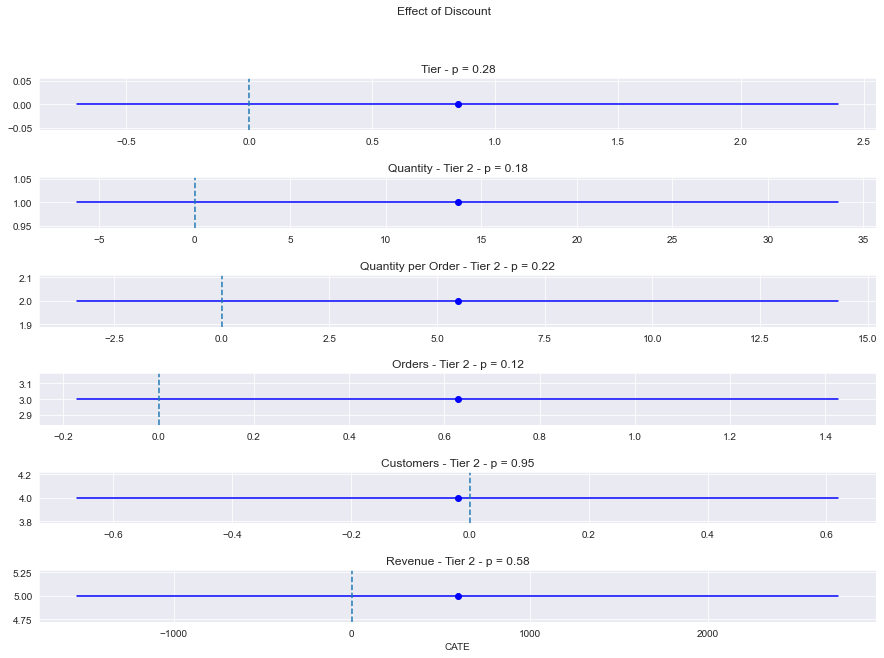

In [134]:
# conditional average treatment effect for confirmation
# condition female
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.9)

coefs = []
i = 0

# plot tier effects
ax = plt.subplot(len(effects) + 1, 1, i + 1)
result = ols('Tier ~ C(ProductFamilyID) + discount', data=data[(data.ProductFamilyID.isin(fams)) & (data.avg_qty != 0)]).fit()
coef = result.params[4]
l = result.conf_int().iloc[4].tolist()
ax.plot(l, [i, i], c='blue')
ax.scatter(coef, i, c='blue')

titles = ['Quantity', 'Quantity per Order', 'Orders', 'Customers', 'Revenue']
ax.set_title('Tier' + ' - p = ' + str(result.pvalues[4].round(2)))
i += 1

# vline at x = 0
ax.axvline(0, linestyle='--')

effects = ['quantity', 'avg_qty', 'orders', 'customers', 'revenue']
for effect in effects:
    ax = plt.subplot(len(effects) + 1, 1, i + 1)
    result = ols('{} ~ C(ProductFamilyID) + discount'.format(effect), data=data[(data.ProductFamilyID.isin(fams)) & (data.Tier == 2)]).fit()
    coef = result.params[4]
    l = result.conf_int().iloc[4].tolist()
    ax.plot(l, [i, i], c='blue')
    ax.scatter(coef, i, c='blue')
    
   #ax.text(0.5, 1.2, 'p = ' + str(result.pvalues[4].round(2)))
    
    ax.axvline(0, linestyle='--')
    ax.set_title('{}'.format(titles[i-1]) + ' - Tier 2' + ' - p = ' + str(result.pvalues[4].round(2)))
    
    i += 1

# format plot
# ax.set_yticks(np.arange(len(effects)) + 1)
# ax.set_yticklabels(effects)

ax.set_xlabel('CATE')
plt.suptitle('Effect of Discount')

plt.show()

In [51]:
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier', 'is_2022', 'discount'], as_index=False)[['profit', 'quantity']].sum()

data_.loc[data_.Tier == 2].groupby(['ProductFamilyID', 'is_2022'])[['profit', 'quantity']].mean()

data_.loc[data_.Tier == 2].groupby(['ProductFamilyID'])[['profit', 'quantity']].mean()

profit    quantity
ProductFamilyID                          
1923             13910.987778  302.333333
2076              6310.780000  140.888889
2684             13556.562222  243.888889
2955              3254.207778   45.888889
2956             11008.231111  214.888889
3044              4270.706667   43.444444
3227              5693.828889   47.888889
3403              6914.333333   72.555556

In [29]:
data_ = data.groupby(['month_str', 'ProductFamilyID', 'Tier', 'is_2022', 'discount'], as_index=False)['quantity'].sum()
x = data_.pivot_table(index=['month_str', 'ProductFamilyID', 'is_2022', 'discount'], columns='Tier', values='quantity', aggfunc=sum).reset_index().copy()
x['Tier 2/Tier 1'] = x[2]/x[1]

x = x.rename(columns={1:'T1', 2:'T2'})
x['pid_id'] = x.ProductFamilyID.rank(method='dense').astype(int)

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x[['T1', 'T2']] = scaler.fit_transform(x[['T1', 'T2']])

x.head()

Tier month_str  ProductFamilyID  is_2022  discount   T1   T2    3    4  \
0      2021-01             1923        0       0.2  154  178  132  100   
1      2021-01             2076        0       0.2   54  136    0    0   
2      2021-01             2684        0       0.2  150  330  128    0   
3      2021-01             2955        0       0.2  126   70   60    0   
4      2021-01             2956        0       0.2  234  268  160    0   

Tier  Tier 2/Tier 1  pid_id  
0          1.155844       1  
1          2.518519       2  
2          2.200000       3  
3          0.555556       4  
4          1.145299       5

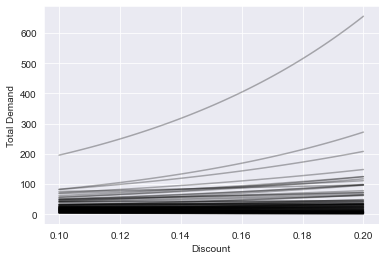

In [285]:
# choose beta prior
N = 100
b0 = stats.norm.rvs(3, 0.5, size=N)
b1 = stats.norm.rvs(0, 5, size=N)
b2 = stats.norm.rvs(0, 5, size=N)

# disount
R = np.linspace(0.10, 0.2, 100)

for i in np.arange(N):
    plt.plot(R, np.exp(b0[i] + b2[i]*R), color='black', alpha=0.3)
    
plt.xlabel('Discount')
plt.ylabel('Total Demand')

plt.show()

In [11]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html

# Completely Unpooled

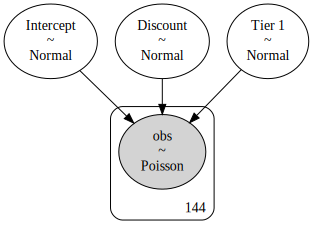

In [17]:
with pm.Model() as com_unpooled_model:    
    # linear coefficient distributions
    b0 = pm.Normal("Intercept", 3, sigma=0.5)
    b1 = pm.Normal("Tier 1", 0.0, sigma=0.5)
    b2 = pm.Normal("Discount", 0.0, sigma=0.5)
    
    # mean demand
    theta = b0+ b1*x['discount'] + b2*x['discount']
    
    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=x["T2"].values)

pm.model_to_graphviz(com_unpooled_model)

In [18]:
with com_unpooled_model:
    com_unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discount, Tier 1, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 49 seconds.
The acceptance probability does not match the target. It is 0.8948365982262129, but should be close to 0.8. Try to increase the number of tuning steps.


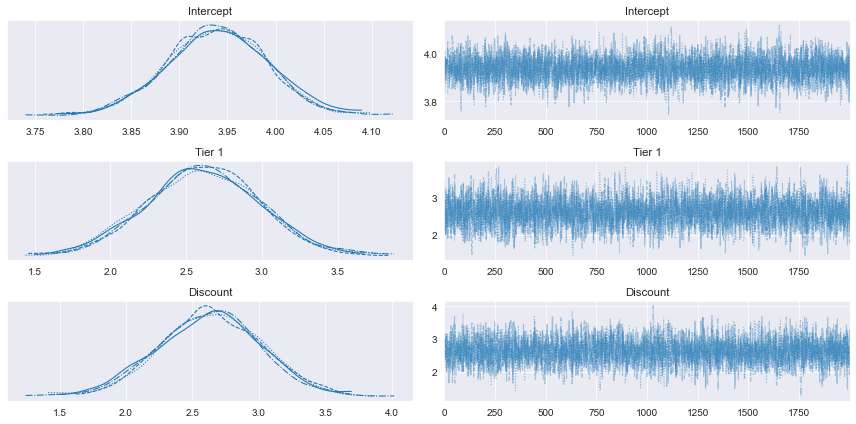

In [19]:
az.plot_trace(com_unpooled_trace, var_names=["Intercept", "Tier 1", "Discount"]);

plt.tight_layout()
plt.show()

In [21]:
az.summary(np.exp(com_unpooled_trace.posterior), kind="stats")

mean     sd  hdi_3%  hdi_97%
Intercept  51.456  2.680  46.556   56.609
Tier 1     14.645  5.675   5.655   24.647
Discount   14.979  5.811   5.816   25.979

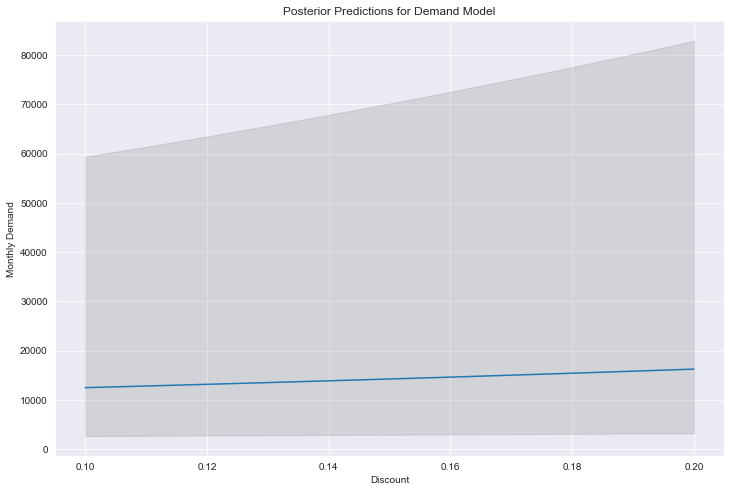

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(com_unpooled_trace.posterior, kind="stats")
b = results['mean']

# discounts
y = np.linspace(0.1, 0.2, 100)

# plot curves 
plt.plot(y, np.exp(b[0] + b[1]*2 + b[-1]*y))

bottom = np.exp(results['hdi_3%'][0] + results['hdi_3%'][1]*2 + results['hdi_3%'][-1]*y)
top = np.exp(results['hdi_97%'][0] + results['hdi_97%'][1]*2 + results['hdi_97%'][-1]*y)

plt.fill_between(y, bottom, top, color='black', alpha=0.1)
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Monthly Demand')
plt.xlabel('Discount')
plt.show()

# average response to discount

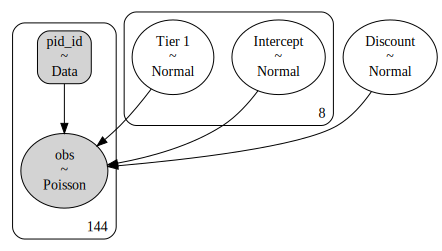

In [59]:
pid_idxs, pid = pd.factorize(x.ProductFamilyID)
coords = {
    "pid": pid,
    "obs_id": np.arange(len(pid_idxs)),
}

with pm.Model(coords=coords) as unpooled_model:
    # as many dimensions as there are observations
    pid_idx = pm.Data("pid_id", pid_idxs, dims="obs_id")
    
    # linear coefficient distributions
    b0 = pm.Normal("Intercept", 3, sigma=0.5, dims='pid')
    b1 = pm.Normal("Tier 1", 0.0, sigma=0.5, dims='pid')
    b2 = pm.Normal("Discount", 0.0, sigma=0.5)
    
    # mean demand
    theta = b0[pid_idx] + b1[pid_idx]*x['discount'] + b2*x['discount']
    
    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=x["T2"].values)

pm.model_to_graphviz(unpooled_model)

In [60]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discount, Tier 1, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.


In [ ]:
az.plot_trace(unpooled_trace, var_names=["Intercept", "Tier 1", "Discount"]);

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(unpooled_trace.posterior, kind="stats")
b = results['mean']

# idx coefficients
int_id = np.argwhere(results.index.isin(['Intercept[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
T1_id = np.argwhere(results.index.isin(['Tier 1[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
dis_id = np.argwhere(results.index.isin(['Discount[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

# discounts
y = np.linspace(0.1, 0.2, 100)

# plot curves
for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    plt.plot(y, np.exp(b[i] + b[j]*y))
    
    bottom = np.exp(results['hdi_3%'][i] + results['hdi_3%'][j]*y)
    top = np.exp(results['hdi_97%'][i] + results['hdi_97%'][j]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)
    
#plt.legend(results.index[fam_id])
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Monthly Demand')
plt.xlabel('Discount')
plt.show()

# Varying Intercepts and Slopes

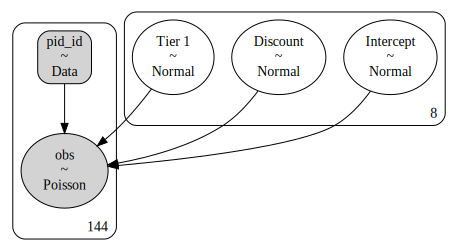

In [32]:
pid_idxs, pid = pd.factorize(x.ProductFamilyID)
coords = {
    "pid": pid,
    "obs_id": np.arange(len(pid_idxs)),
}

with pm.Model(coords=coords) as unpooled_model:
    # as many dimensions as there are observations
    pid_idx = pm.Data("pid_id", pid_idxs, dims="obs_id")
    
    # linear coefficient distributions
    b0 = pm.Normal("Intercept", 3, sigma=0.5, dims='pid')
    b1 = pm.Normal("Tier 1", 0.0, sigma=0.5, dims='pid')
    b2 = pm.Normal("Discount", 0.0, sigma=0.5, dims='pid')
    
    # mean demand
    theta = b0[pid_idx] + b1[pid_idx]*x['discount'] + b2[pid_idx]*x['discount']
    
    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=x["T2"].values)

pm.model_to_graphviz(unpooled_model)

In [33]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discount, Tier 1, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 58 seconds.


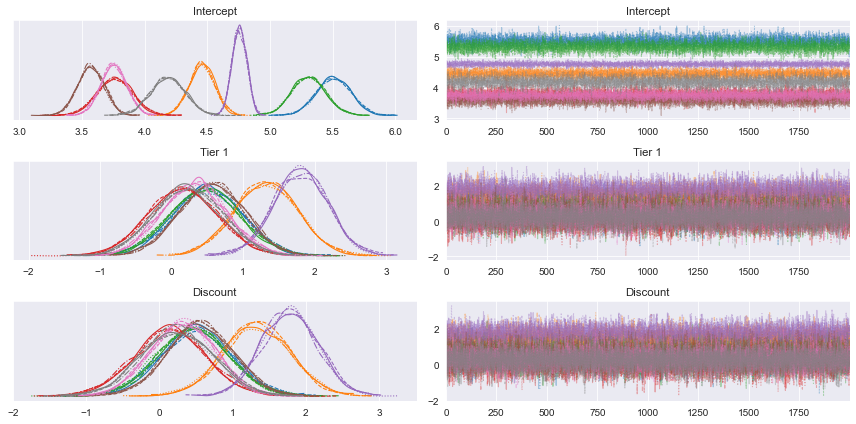

In [35]:
az.plot_trace(unpooled_trace, var_names=["Intercept", "Tier 1", "Discount"]);

plt.tight_layout()
plt.show()

In [56]:
RANDOM_SEED = 60
with unpooled_model:
    ppc = pm.sample_posterior_predictive(
        unpooled_trace, random_seed=RANDOM_SEED
    )

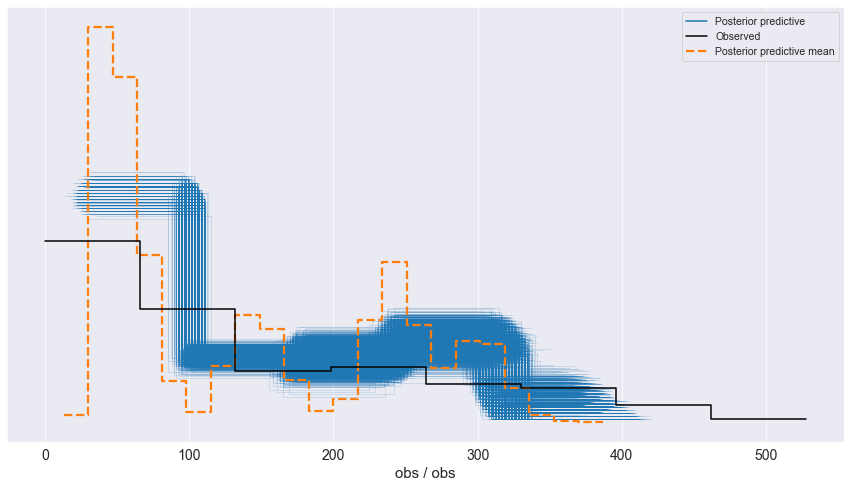

In [57]:
fig, ax = plt.subplots(figsize=(15, 8))

az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=unpooled_model), ax=ax);

In [38]:
# mean squared error
np.sqrt((x.T2 - ppc['obs'].mean(axis=0))**2).mean()

49.908598090277735

In [39]:
az.summary(np.exp(unpooled_trace.posterior), kind="stats")

mean      sd   hdi_3%  hdi_97%
Intercept[1923]  249.204  34.145  187.669  313.793
Intercept[2076]   86.735   8.786   71.044  103.972
Intercept[2684]  204.039  27.518  155.151  256.880
Intercept[2955]   43.435   6.164   31.935   54.616
Intercept[2956]  116.533   6.783  104.316  129.422
Intercept[3044]   35.756   3.794   28.813   42.883
Intercept[3227]   42.859   4.407   34.833   51.353
Intercept[3403]   66.318   9.059   51.214   84.868
Tier 1[1923]       1.863   0.964    0.406    3.503
Tier 1[2076]       4.138   1.927    1.251    7.533
Tier 1[2684]       1.802   0.949    0.473    3.602
Tier 1[2955]       1.316   0.671    0.352    2.548
Tier 1[2956]       6.548   2.586    2.487   11.327
Tier 1[3044]       1.935   0.920    0.588    3.591
Tier 1[3227]       1.524   0.735    0.461    2.886
Tier 1[3403]       1.417   0.713    0.424    2.753
Discount[1923]     1.863   0.979    0.404    3.552
Discount[2076]     4.178   1.990    1.157    7.820
Discount[2684]     1.778   0.922    0.453    3.360
Discount[2955]     1.308   0.692    0.325    2.559
Discount[2956]     6.390   2.519    2.465   11.040
Discount[3044]     1.936   0.916    0.534    3.587
Discount[3227]     1.518   0.693    0.452    2.757
Discount[3403]     1.435   0.743    0.357    2.758

In [329]:
results = az.summary(unpooled_trace.posterior, kind="stats")
b = results['mean']
b

np.argwhere(results.index.isin(['Intercept[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

array([1, 4, 5, 6], dtype=int64)

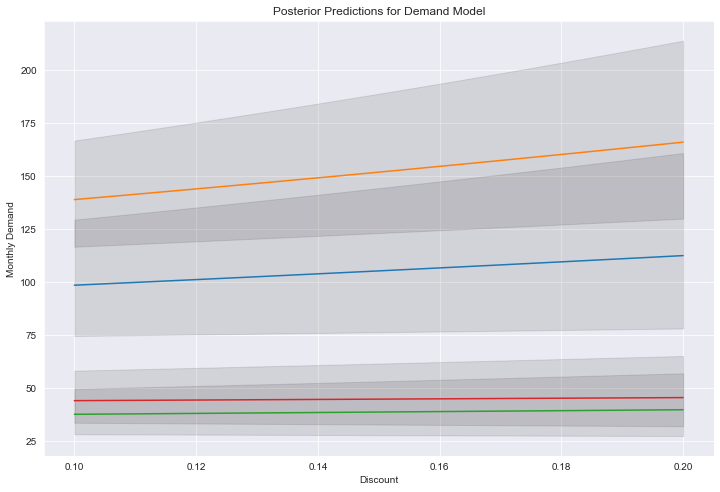

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(unpooled_trace.posterior, kind="stats")
b = results['mean']

# idx coefficients
int_id = np.argwhere(results.index.isin(['Intercept[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
T1_id = np.argwhere(results.index.isin(['Tier 1[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
dis_id = np.argwhere(results.index.isin(['Discount[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

# discounts
y = np.linspace(0.1, 0.2, 100)

# plot curves
for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    plt.plot(y, np.exp(b[i] + b[j]*y))
    
    bottom = np.exp(results['hdi_3%'][i] + results['hdi_3%'][j]*y)
    top = np.exp(results['hdi_97%'][i] + results['hdi_97%'][j]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)
    
#plt.legend(results.index[fam_id])
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Monthly Demand')
plt.xlabel('Discount')
plt.show()

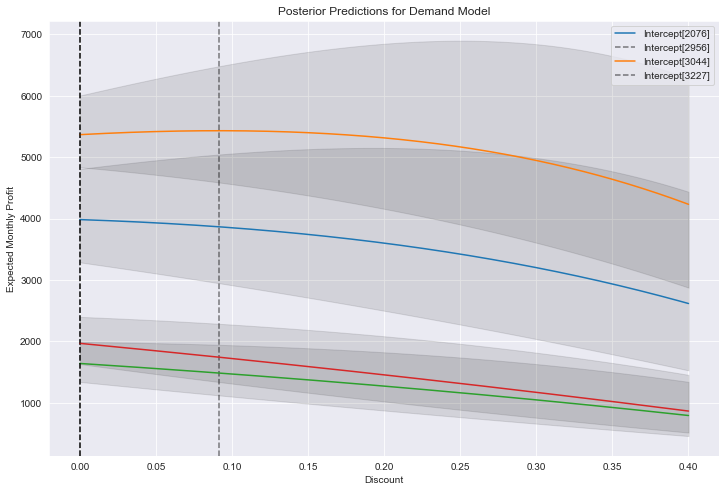

In [42]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(unpooled_trace.posterior, kind="stats")
b = results['mean']

# plot base curve
y = np.linspace(0, 0.4, 1000)

# idx coefficients
int_id = np.argwhere(results.index.isin(['Intercept[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
T1_id = np.argwhere(results.index.isin(['Tier 1[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
dis_id = np.argwhere(results.index.isin(['Discount[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

# plot curves
for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    avg_price = data2.loc['Intercept[' + data2.ProductFamilyID.astype(str) + ']' == results.index[int_id[0]], 'avg_price'].iloc[0]
    
    exp_demand = np.exp(b[i] + b[j]*y)
    revenue = avg_price*(1 - y)
    cost = data2.loc['Intercept[' + data2.ProductFamilyID.astype(str) + ']' == results.index[int_id[0]], 'avg_cost'].iloc[0]
    
    profit = (revenue - cost)*exp_demand
    plt.plot(y, profit)
    
    # max profit vertical line
    plt.axvline(y[np.argmax(profit)], linestyle='--', color='black', alpha=0.5)

plt.legend(results.index[int_id])

for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    avg_price = data2.loc['Intercept[' + data2.ProductFamilyID.astype(str) + ']' == results.index[int_id[0]], 'avg_price'].iloc[0]
    
    exp_demand = np.exp(b[i] + b[j]*y)
    revenue = avg_price*(1 - y)
    cost = data2.loc['Intercept[' + data2.ProductFamilyID.astype(str) + ']' == results.index[int_id[0]], 'avg_cost'].iloc[0]
    
    bottom = (revenue - cost)*np.exp(results['hdi_3%'][i] + results['hdi_3%'][j]*y)
    top = (revenue - cost)*np.exp(results['hdi_97%'][i] + results['hdi_97%'][j]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)

plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Expected Monthly Profit')
plt.xlabel('Discount')
plt.show()

# Hierarchical Model

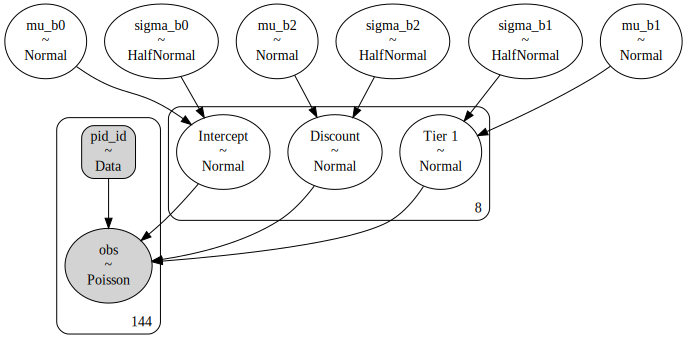

In [450]:
pid_idxs, pid = pd.factorize(x.ProductFamilyID)
coords = {
    "pid": pid,
    "obs_id": np.arange(len(pid_idxs)),
}

with pm.Model(coords=coords) as hier_model:
    # as many dimensions as there are observations
    pid_idx = pm.Data("pid_id", pid_idxs, dims="obs_id")
    
    # Hyperpriors for group nodes
    mu_b0 = pm.Normal("mu_b0", mu=3, sigma=1.5)
    sigma_b0 = pm.HalfNormal("sigma_b0", 1)
    mu_b1 = pm.Normal("mu_b1", mu=0, sigma=1.5)
    sigma_b1 = pm.HalfNormal("sigma_b1", 1)
    mu_b2 = pm.Normal("mu_b2", mu=0, sigma=0.5)
    sigma_b2 = pm.HalfNormal("sigma_b2", 1)
    
    # linear coefficient distributions
    b0 = pm.Normal("Intercept", mu_b0, sigma=sigma_b0, dims='pid')
    b1 = pm.Normal("Tier 1", mu_b1, sigma=sigma_b1, dims='pid')
    b2 = pm.Normal("Discount", mu_b2, sigma=sigma_b2, dims='pid')
    
    # mean demand
    theta = b0[pid_idx] + b1[pid_idx]*x['discount'] + b2[pid_idx]*x['discount']
    
    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=x["T2"].values)
    
    
pm.model_to_graphviz(hier_model)

In [451]:
with hier_model:
    hier_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discount, Tier 1, Intercept, sigma_b2, mu_b2, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 146 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


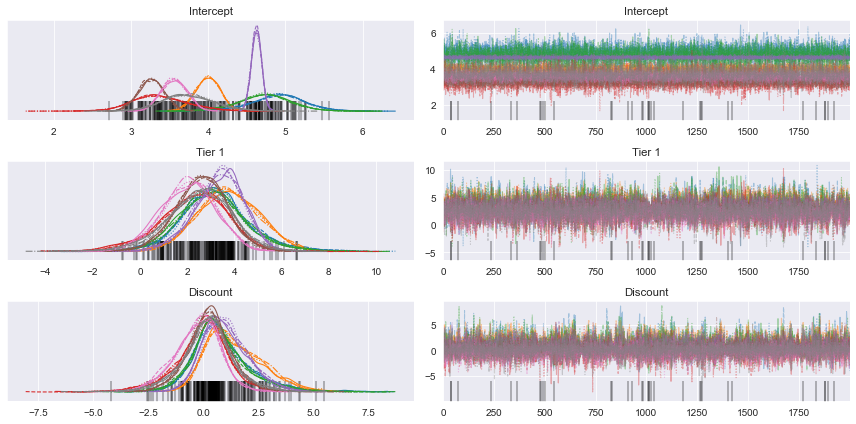

In [452]:
az.plot_trace(hier_trace, var_names=["Intercept", "Tier 1", "Discount"]);

plt.tight_layout()
plt.show()

In [453]:
with hier_model:
    prior_checks = pm.sample_prior_predictive(
        samples=50, random_seed=RANDOM_SEED
    )

prior_checks['Intercept'][0,0]*y
prior_checks['obs'][:,0]

array([ 11,   1,   5,  93,   8,   8,  10,   4,  12,  60,  12,   1,  14,
        38,   5, 107,  11,  12,  31, 244,  59,   2,   1,  13,   0,  13,
        11,   1, 253, 108, 770,  10,  10,  33,   9,  17,   4, 391,  33,
        37, 825,  16,  27,  46,  17,  10,  44,  29, 175, 968])

C:\Users\mlentini\AppData\Local\Temp\ipykernel_3740\758420428.py:8: RuntimeWarning: overflow encountered in exp
  y_ = np.exp(prior_checks['obs'][i,0] + prior_checks['Intercept'][i,0]*y)


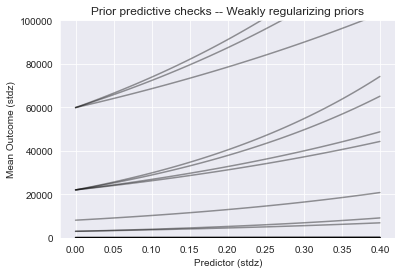

In [454]:
_, ax = plt.subplots()

# discounts
y = np.linspace(0, 0.4, 100)

# plot priors
for i in range(50):
    y_ = np.exp(prior_checks['obs'][i,0] + prior_checks['Intercept'][i,0]*y)
    
    ax.plot(y, y_, c="k", alpha=0.4)
    ax.set_ylim(0, 100000)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

In [53]:
RANDOM_SEED = 58
with hier_model:
    heir_ppc = pm.sample_posterior_predictive(
        hier_trace, random_seed=RANDOM_SEED
    )

NameError: name 'hier_model' is not defined

NameError: name 'heir_ppc' is not defined

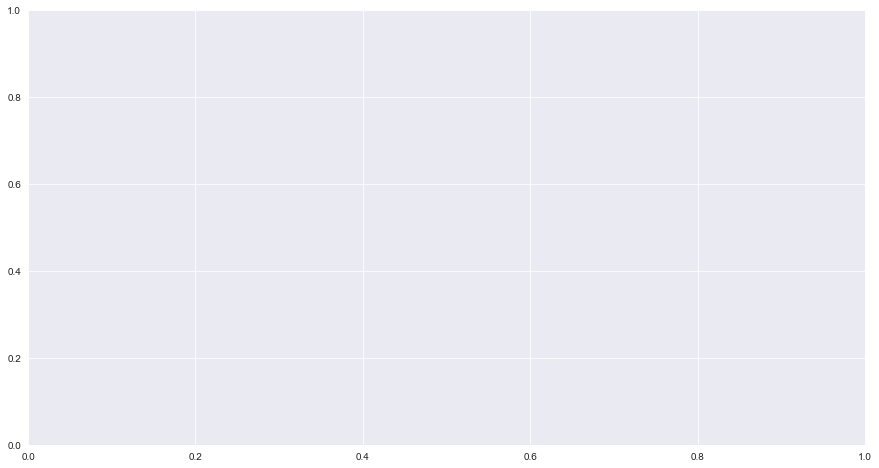

In [52]:
fig, ax = plt.subplots(figsize=(15, 8))

az.plot_ppc(az.from_pymc3(posterior_predictive=heir_ppc, model=hier_model), ax=ax);

In [484]:
# mean squared error
np.sqrt((x.T2 - heir_ppc['obs'].mean(axis=0))**2).mean()

50.06347222222221

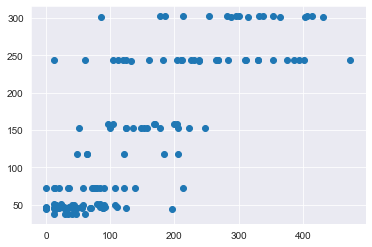

In [480]:
plt.scatter(x.T2, ppc['obs'].mean(axis=0))
plt.show()

In [455]:
az.summary(np.exp(hier_trace.posterior), kind="stats")

mean       sd  hdi_3%  hdi_97%
mu_b0             56.445   17.664  26.018   89.841
mu_b1             20.534   20.421   0.575   53.996
mu_b2              1.521    0.782   0.415    2.952
Intercept[1923]  142.954   52.750  52.390  237.259
Intercept[2076]   54.946    8.592  39.967   71.379
Intercept[2684]  119.591   42.753  49.235  198.090
Intercept[2955]   31.361   12.473  13.350   55.541
Intercept[2956]  102.126    6.671  89.714  114.789
Intercept[3044]   26.511    4.511  18.774   35.266
Intercept[3227]   35.580    5.968  24.945   46.580
Intercept[3403]   45.300   17.316  18.735   75.666
Tier 1[1923]     125.579  915.217   0.019  279.990
Tier 1[2076]      99.021  189.084   0.283  334.143
Tier 1[2684]      91.793  615.876   0.021  221.433
Tier 1[2955]      36.807  417.587   0.015   80.409
Tier 1[2956]      48.153   68.039   0.268  132.766
Tier 1[3044]      24.540   42.388   0.033   69.626
Tier 1[3227]      14.578   20.420   0.032   45.420
Tier 1[3403]      30.990   79.385   0.014   91.283
Discount[1923]    14.444  134.689   0.015   24.417
Discount[2076]    10.912   28.004   0.126   37.578
Discount[2684]     9.949  101.936   0.019   20.259
Discount[2955]     2.066    5.377   0.000    5.634
Discount[2956]     5.296   11.554   0.075   15.564
Discount[3044]     2.380    8.219   0.032    6.309
Discount[3227]     1.260    1.859   0.011    3.253
Discount[3403]     2.631    7.536   0.002    7.337
sigma_b0           2.254    0.701   1.412    3.405
sigma_b1           3.671    3.016   1.046    8.503
sigma_b2           3.640    3.051   1.036    8.492

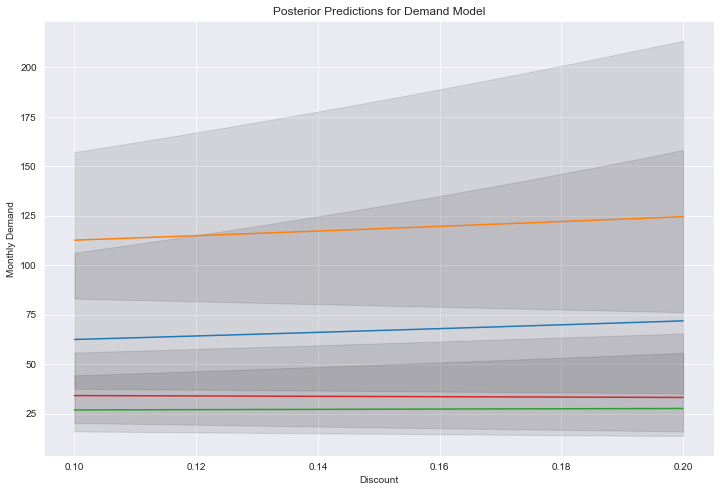

In [456]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(hier_trace.posterior, kind="stats")
b = results['mean']

# idx coefficients
int_id = np.argwhere(results.index.isin(['Intercept[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
T1_id = np.argwhere(results.index.isin(['Tier 1[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
dis_id = np.argwhere(results.index.isin(['Discount[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

# discounts
y = np.linspace(0.1, 0.2, 100)

# plot curves
for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    plt.plot(y, np.exp(b[i] + b[j]*y))
    
    bottom = np.exp(results['hdi_3%'][i] + results['hdi_3%'][j]*y)
    top = np.exp(results['hdi_97%'][i] + results['hdi_97%'][j]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)
    
#plt.legend(results.index[fam_id])
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Monthly Demand')
plt.xlabel('Discount')
plt.show()

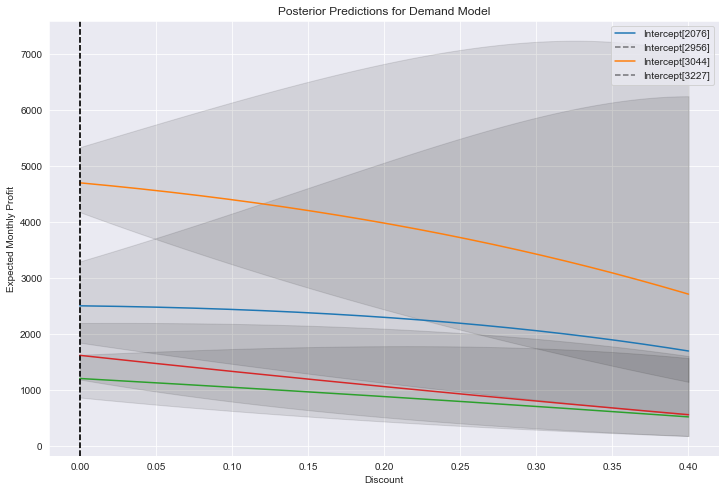

In [457]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(hier_trace.posterior, kind="stats")
b = results['mean']

# plot base curve
y = np.linspace(0, 0.4, 1000)

# idx coefficients
int_id = np.argwhere(results.index.isin(['Intercept[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
T1_id = np.argwhere(results.index.isin(['Tier 1[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
dis_id = np.argwhere(results.index.isin(['Discount[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

# plot curves
for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    avg_price = data2.loc['Intercept[' + data2.ProductFamilyID.astype(str) + ']' == results.index[int_id[0]], 'avg_price'].iloc[0]
    
    exp_demand = np.exp(b[i] + b[j]*y)
    revenue = avg_price*(1 - y)
    cost = data2.loc['Intercept[' + data2.ProductFamilyID.astype(str) + ']' == results.index[int_id[0]], 'avg_cost'].iloc[0]
    
    profit = (revenue - cost)*exp_demand
    plt.plot(y, profit)
    
    # max profit vertical line
    plt.axvline(y[np.argmax(profit)], linestyle='--', color='black', alpha=0.5)

plt.legend(results.index[int_id])

for k in range(len(int_id)):
    
    i = int_id[k]
    j = dis_id[k]
    
    bottom = (revenue - cost)*np.exp(results['hdi_3%'][i] + results['hdi_3%'][j]*y)
    top = (revenue - cost)*np.exp(results['hdi_97%'][i] + results['hdi_97%'][j]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)

plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Expected Monthly Profit')
plt.xlabel('Discount')
plt.show()

# Varying-Intercept Model

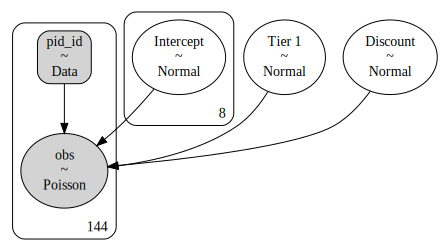

In [488]:
pid_idxs, pid = pd.factorize(x.ProductFamilyID)
coords = {
    "pid": pid,
    "obs_id": np.arange(len(pid_idxs)),
}

with pm.Model(coords=coords) as pooled_model:
    # as many dimensions as there are observations
    pid_idx = pm.Data("pid_id", pid_idxs, dims="obs_id")
    
    # linear coefficient distributions
    b0 = pm.Normal("Intercept", 3, sigma=0.5, dims='pid')
    b1 = pm.Normal("Tier 1", 0.0, sigma=0.5)
    b2 = pm.Normal("Discount", 0.0, sigma=0.5)
    
    # mean demand
    theta = b0[pid_idx] + b1*x['discount'] + b2*x['discount']
    
    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=x["T2"].values)

pm.model_to_graphviz(pooled_model)

In [489]:
with pooled_model:
    pooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discount, Tier 1, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [490]:
RANDOM_SEED = 58
with pooled_model:
    pooled_ppc = pm.sample_posterior_predictive(
        pooled_trace, random_seed=RANDOM_SEED
    )

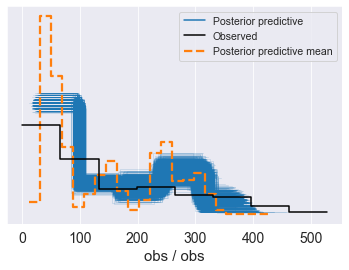

In [492]:
az.plot_ppc(az.from_pymc3(posterior_predictive=pooled_ppc, model=pooled_model));

In [493]:
# mean squared error
np.sqrt((x.T2 - pooled_ppc['obs'].mean(axis=0))**2).mean()

49.858486979166656

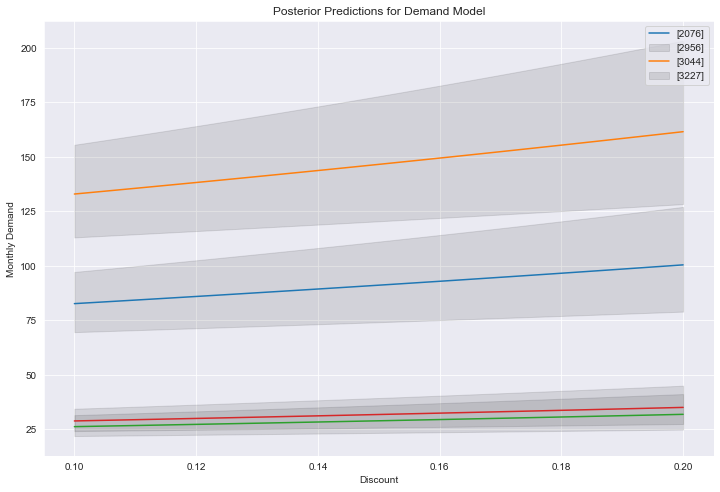

In [299]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(unpooled_trace.posterior, kind="stats")
b = results['mean']

fam_id = np.argwhere(results.index.isin(['[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()
y = np.linspace(0.1, 0.2, 100)

# plot curves
for i in fam_id:
    plt.plot(y, np.exp(b[i] + b[-1]*y))
    
    bottom = np.exp(results['hdi_3%'][i] + results['hdi_3%'][-1]*y)
    top = np.exp(results['hdi_97%'][i] + results['hdi_97%'][-1]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)
    
#plt.legend(data_.ProductFamilyID.unique())
plt.legend(results.index[fam_id])
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Monthly Demand')
plt.xlabel('Discount')
plt.show()

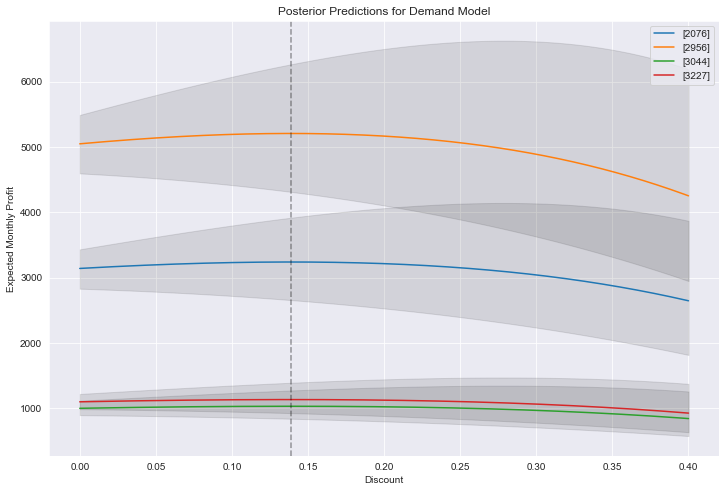

In [318]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(unpooled_trace.posterior, kind="stats")
b = results['mean']

# plot base curve
y = np.linspace(0, 0.4, 1000)
fam_id = np.argwhere(results.index.isin(['[' + str(x) + ']' for x in fams])).reshape(1, -1).ravel()

# plot curves
for i in fam_id:
    
    avg_price = data2.loc['[' + data2.ProductFamilyID.astype(str) + ']' == results.index[fam_id[0]], 'avg_price'].iloc[0]
    exp_demand = np.exp(b[i] + b[-1]*y)
    revenue = avg_price*(1 - y)
    cost = data2.loc['[' + data2.ProductFamilyID.astype(str) + ']' == results.index[fam_id[0]], 'avg_cost'].iloc[0]
    
    profit = (revenue - cost)*exp_demand
    plt.plot(y, profit)

plt.legend(results.index[fam_id])

for i in fam_id:
    bottom = (revenue - cost)*np.exp(results['hdi_3%'][i] + results['hdi_3%'][-1]*y)
    top = (revenue - cost)*np.exp(results['hdi_97%'][i] + results['hdi_97%'][-1]*y)
    
    plt.fill_between(y, bottom, top, color='black', alpha=0.1)
    
    plt.axvline(y[np.argmax(profit)], linestyle='--', color='black', alpha=0.1)

plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Expected Monthly Profit')
plt.xlabel('Discount')
plt.show()

## Model as hierarchical Poisson
Assume that PID demand $D_i$ (quantity demanded) comes from a Poisson process, and that the average demand $\lambda_i$ depends on the multi-pricing discount $R_i$ via the log-link function:


$D_i \sim \text{Poisson}(\lambda_i)$

$\log(\lambda_i) = \alpha_i + \beta_i R_i$ 

2.843281828459045


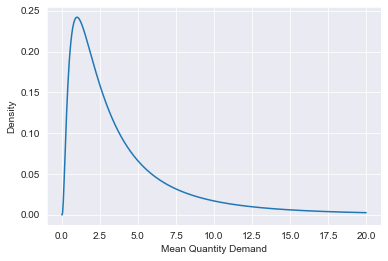

In [286]:
# choose prior params
scale = 1
mu = 1
s = 0.5

# plot plausible alpha prior
x = np.linspace(0, 20, 1000)
prior_a = stats.lognorm.pdf(x, s=s, loc=0, scale=np.exp(mu))
plt.plot(x, prior)

# print mean demand from prior
print(np.exp(mu) + s**2/2)

# labels
plt.xlabel('Mean Quantity Demand')
plt.ylabel('Density')

plt.show()

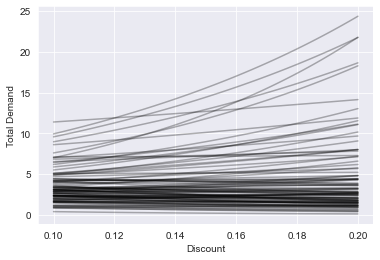

In [299]:
# choose beta prior
N = 100
a = stats.norm.rvs(1, 0.5, size=N)
b = stats.norm.rvs(0, 5, size=N)

# disount
R = np.linspace(0.10, 0.2, 100)

for i in np.arange(N):
    plt.plot(R, np.exp(a[i] + b[i]*R), color='black', alpha=0.3)
    
plt.xlabel('Discount')
plt.ylabel('Total Demand')

plt.show()

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import xarray as xr

from formulae import design_matrices
print(f"Running on PyMC3 v{pm.__version__}")

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


In [341]:
data_.month

39840      2021-12
39842      2021-02
39843      2021-08
39846      2021-12
39849      2021-11
            ...   
1517227    2022-05
1517231    2021-11
1517232    2021-07
1517233    2021-10
1517235    2021-01
Name: month, Length: 15872, dtype: period[M]

In [359]:
data_ = data.copy()
data_['int_day'] = (data_.date - data_.date.min()).dt.days
data_['int_month'] = data_.month.rank(ascending=True, method='dense').astype(int)

data_ = data_[
        (data.ProductFamilyID.isin(fams + ctrl)) &
        (data.Tier == 2)
    ].groupby(['ProductFamilyID', 'Tier', 'discount', 'month', 'int_month'], as_index=False).quantity.sum()\

data_.ProductFamilyID = data_.ProductFamilyID.astype(str)

data_.head()

ProductFamilyID  Tier  discount    month  int_month  quantity
0            1923     2       0.2  2021-01          1       178
1            1923     2       0.2  2021-02          2       282
2            1923     2       0.2  2021-03          3       254
3            1923     2       0.2  2021-04          4       432
4            1923     2       0.2  2021-05          5       364

In [394]:
# tier 2 demand with discount
cols = ['ProductFamilyID', 'quantity', 'discount']
data_ = data[
        (data.ProductFamilyID.isin(fams + ctrl)) &
        (data.Tier == 2)
    ].groupby(['ProductFamilyID', 'Tier', 'discount', 'month'], as_index=False).quantity.sum()\

print(data_.shape)

data_ = data_.merge(data2, left_on='ProductFamilyID', right_on='ProductFamilyID')
data_.ProductFamilyID = data_.ProductFamilyID.astype(str)

data_['price'] = (data_.avg_price - data_.avg_price.mean())/data_.avg_price.std()

data_.head()

(144, 5)


ProductFamilyID  Tier  discount    month  quantity  avg_price   avg_cost  \
0            1923     2       0.2  2021-01       178  67.222412  22.931166   
1            1923     2       0.2  2021-02       282  67.222412  22.931166   
2            1923     2       0.2  2021-03       254  67.222412  22.931166   
3            1923     2       0.2  2021-04       432  67.222412  22.931166   
4            1923     2       0.2  2021-05       364  67.222412  22.931166   

      price  
0 -1.039262  
1 -1.039262  
2 -1.039262  
3 -1.039262  
4 -1.039262

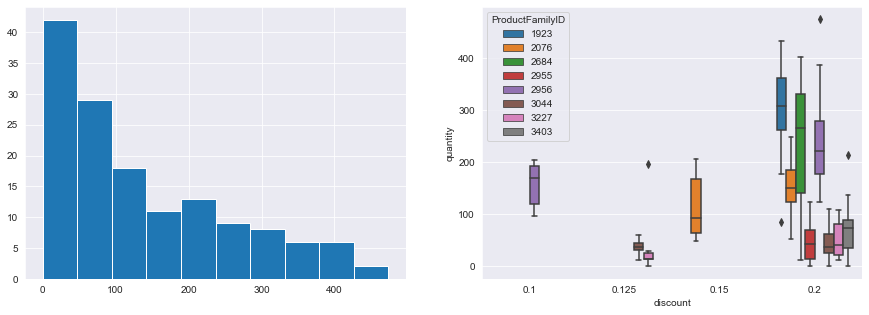

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

data_.quantity.hist(ax=ax[0])

sns.boxplot(data=data_, x='discount', y='quantity', hue='ProductFamilyID', ax=ax[1])
plt.show()

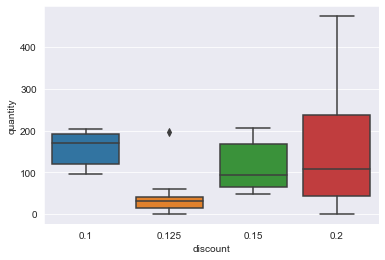

In [199]:
sns.boxplot(data=data_, x='discount', y='quantity')
plt.show()

https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-poisson-regression.html

https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/posterior_predictive.html

In [200]:
data_.ProductFamilyID.unique()

array(['1923', '2076', '2684', '2955', '2956', '3044', '3227', '3403'],
      dtype=object)

In [417]:
fml = "quantity ~ ProductFamilyID + discount"  # lazy formulae formulation
dm = design_matrices(fml, data_, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex.head()

Intercept  ProductFamilyID[2076]  ProductFamilyID[2684]  \
0        1.0                    0.0                    0.0   
1        1.0                    0.0                    0.0   
2        1.0                    0.0                    0.0   
3        1.0                    0.0                    0.0   
4        1.0                    0.0                    0.0   

   ProductFamilyID[2955]  ProductFamilyID[2956]  ProductFamilyID[3044]  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   ProductFamilyID[3227]  ProductFamilyID[3403]  discount  
0                    0.0                    0.0       0.2  
1                    0.0                    0.0       0.2  
2                    0.0                    0.0       0.2  
3                    0.0                    0.0       0.2  
4                    0.0                    0.0       0.2

In [418]:
with pm.Model() as model_1:

    # define priors, weakly informative Normal
    mu = 0
    b0 = pm.Normal("Intercept", mu=0.5, sigma=0.5)
    b1 = pm.Normal("2076", mu=mu, sigma=5)
    b2 = pm.Normal("2684", mu=mu, sigma=5)
    b3 = pm.Normal("2955", mu=mu, sigma=5)
    b4 = pm.Normal("2956", mu=mu, sigma=5)
    b5 = pm.Normal("3044", mu=mu, sigma=5)
    b6 = pm.Normal("3227", mu=mu, sigma=5)
    b7 = pm.Normal("3403", mu=mu, sigma=5)
    b8 = pm.Normal("Discount", mu=mu, sigma=5)
    #b9 = pm.Normal("Price", mu=0, sigma=1)

    # define linear model and exp link function
    theta = b0  + \
        b1 * mx_ex["ProductFamilyID[2076]"] + \
        b2 * mx_ex["ProductFamilyID[2684]"] + \
        b3 * mx_ex["ProductFamilyID[2955]"] + \
        b4 * mx_ex["ProductFamilyID[2956]"] + \
        b5 * mx_ex["ProductFamilyID[3044]"] + \
        b6 * mx_ex["ProductFamilyID[3227]"] + \
        b7 * mx_ex["ProductFamilyID[3403]"] + \
        b8 * mx_ex["discount"] #+ b9 * mx_ex["price"]
        

    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=mx_en["quantity"].values)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

In [419]:
with pm.Model() as model_1:

    # define priors, weakly informative Normal
    mu = 0
    b0 = pm.Normal("Intercept", mu=0.5, sigma=0.5)
    b1 = pm.Normal("2956", mu=mu, sigma=5)
    b2 = pm.Normal("3044", mu=mu, sigma=5)
    b3 = pm.Normal("3227", mu=mu, sigma=5)
    b4 = pm.Normal("Discount", mu=mu, sigma=5)

    # define linear model and exp link function
    theta = b0  + \
        b1 * mx_ex["ProductFamilyID[2956]"] + \
        b2 * mx_ex["ProductFamilyID[3044]"] + \
        b3 * mx_ex["ProductFamilyID[3227]"] + \
        b4 * mx_ex["discount"] 

    ## Define Poisson likelihood
    obs = pm.Poisson("obs", mu=np.exp(theta), observed=mx_en["quantity"].values)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

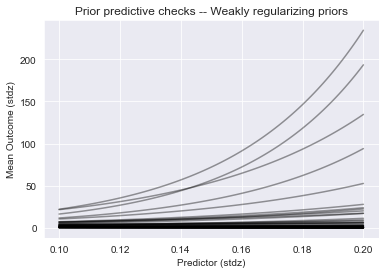

In [420]:
_, ax = plt.subplots()

# discounts
x = np.linspace(0.1, 0.2, 100)

# plot priors
for b0, b1, b2, b3, b4 in zip(prior_checks["Intercept"], prior_checks["3044"], prior_checks["2956"], prior_checks["3227"], prior_checks["Discount"]):
    y = np.exp(b0 + b1*x + b2*x + b3*x + b3*x)
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

In [421]:
with model_1:
    trace_1 = pm.sample(1000, tune=5000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Discount, 3227, 3044, 2956, Intercept]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 70 seconds.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5480072598374003, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


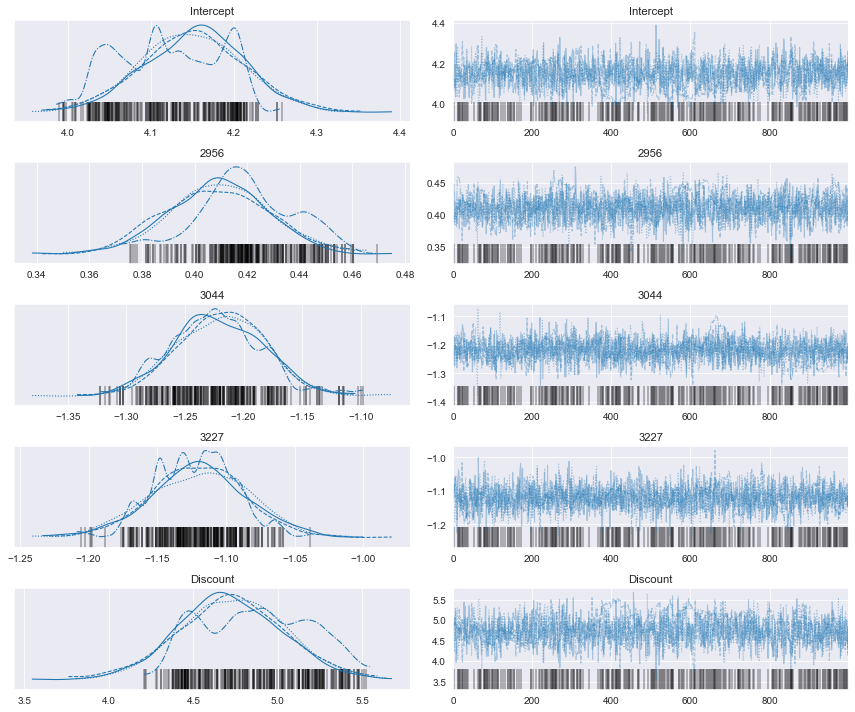

In [414]:
# trace plot
az.plot_trace(trace_1)
plt.tight_layout()

In [415]:
RANDOM_SEED = 58
with model_1:
    ppc = pm.sample_posterior_predictive(
        trace_1, random_seed=RANDOM_SEED
    )

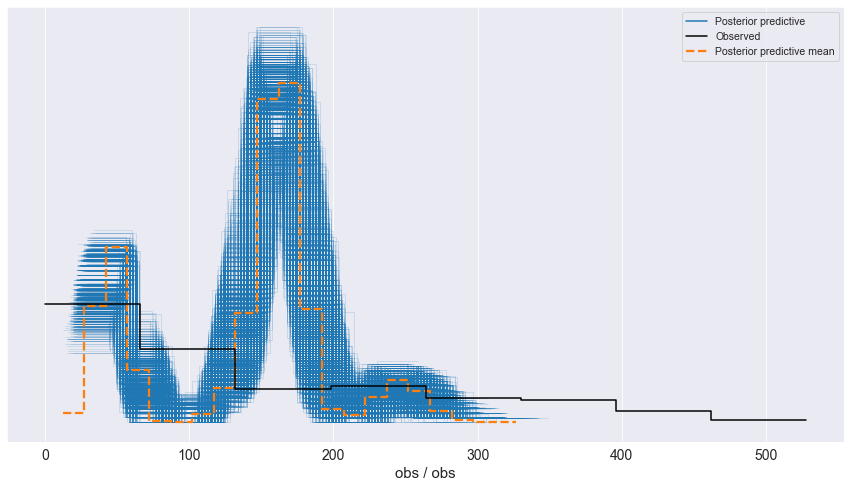

In [416]:
fig, ax = plt.subplots(figsize=(15, 8))

az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_1), ax=ax)
plt.show()

In [409]:
az.summary(np.exp(trace_1.posterior), kind="stats")

mean      sd  hdi_3%  hdi_97%
Intercept   63.088   3.965  55.886   70.249
2956         1.510   0.030   1.455    1.566
3044         0.295   0.011   0.274    0.315
3227         0.326   0.011   0.306    0.348
Discount   122.969  39.722  53.367  196.896

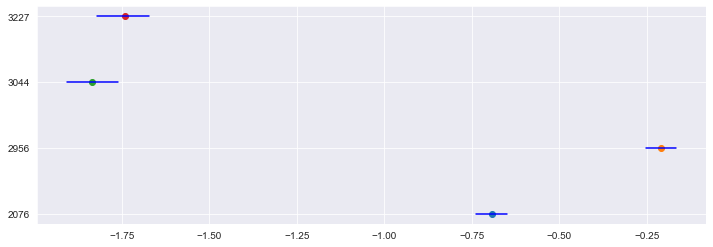

In [261]:
fig, ax = plt.subplots(figsize=(12,4))


fam_id = np.argwhere(results.index.isin([str(x) for x in fams])).reshape(1, -1).ravel()

j = 0
for i in fam_id:
    
    a = results['hdi_3%'][i]
    b = results['hdi_97%'][i]
    ax.plot([a, b], [j, j], c='blue')
    ax.scatter(results['mean'][i], j)
    
    j += 1
    
ax.set_yticks(np.arange(len(fam_id)))
ax.set_yticklabels(results.index[fam_id])

plt.show()

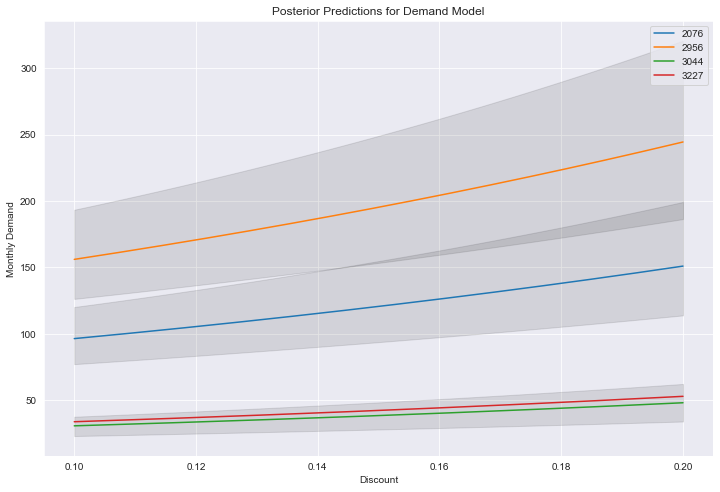

In [275]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(trace_1.posterior, kind="stats")
b = results['mean']

# plot base curve
# x = np.linspace(0.1, 0.2, 1000)
# plt.plot(x, np.exp(b[0] + b[4]*x))

fam_id = np.argwhere(results.index.isin([str(x) for x in fams])).reshape(1, -1).ravel()

diff = []

# plot curves
for i in fam_id:
    plt.plot(x, np.exp(b[0] + b[i] + b[-1]*x))
    
    l = np.exp(b[0] + b[i] + b[-1]*x)
    diff.append((l[-1] - l[0]))
    
#plt.legend(data_.ProductFamilyID.unique())
plt.legend(results.index[fam_id])

# add shade
# bottom = np.exp(results['hdi_3%'][0] + results['hdi_3%'][-1]*x)
# top = np.exp(results['hdi_97%'][0] + results['hdi_97%'][-1]*x)
    
# plt.fill_between(x, bottom, top, color='black', alpha=0.1)
    
for i in np.arange(3) + 1:
    bottom = np.exp(results['hdi_3%'][0] + results['hdi_3%'][i] + results['hdi_3%'][-1]*x)
    top = np.exp(results['hdi_97%'][0] + results['hdi_97%'][i] + results['hdi_97%'][-1]*x)
    
    plt.fill_between(x, bottom, top, color='black', alpha=0.1)
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Monthly Demand')
plt.xlabel('Discount')
plt.show()

In [277]:
ch = pd.DataFrame(np.array(diff).round()).T

ch.columns = results.index[fam_id]
ch.index=['Demand Change']

ch

2076  2956  3044  3227
Demand Change  55.0  88.0  17.0  19.0

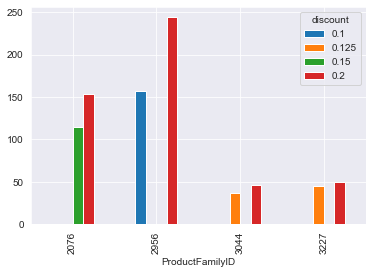

In [185]:
data_.groupby(['ProductFamilyID', 'discount']).quantity.mean().unstack().plot(kind='bar')
plt.show()

In [378]:
ctrl

[2684, 3403, 2955, 1923]

In [14]:
import pyodbc
cnxn_str = ("Driver={ODBC Driver 17 for SQL Server};"
            "Server=BI;"
            "Database=BI_Production;"
            "Trusted_Connection=yes;")

cnxn = pyodbc.connect(cnxn_str)
cursor = cnxn.cursor()

query = """
SELECT  
	md.ProductFamilyID,
	avg(ph.Tier_2_Price) as 'avg_price',
	avg(mm.CalculatedCost) as 'avg_cost'
FROM PriceHistory ph
LEFT JOIN MaterialDimension md on md.Matnr = ph.Material
LEFT JOIN MaterialMaster mm on mm.MATNR = ph.Material
WHERE ph.SalesOrg = 1000
	AND md.ProductFamilyID in ('2956', '3044', '3227', '2076', '2684', '3403', '2955', '1923')
	AND year(ph.Start_Date) = 2021 
	AND ph.Currency = 'USD'
    AND mm.Plant = 1000

GROUP BY md.ProductFamilyID
"""

cursor.execute(query).fetchall()
data2 = pd.read_sql(query, cnxn)

data2.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


ProductFamilyID   avg_price    avg_cost
0             1923   67.247687   23.030817
1             2076   70.778306   24.631436
2             2684   83.335580   29.204872
3             2955  238.616632  128.326866
4             2956   88.078795   35.230150

In [296]:
data2.loc[data2.ProductFamilyID.astype(str) == results.index[fam_id[0]], 'avg_price'].iloc[0]

70.7608

In [305]:
avg_price*x*np.exp(b[0] + b[i] + b[-1]*x)

array([206.79336998, 207.09342746, 207.39371294, 207.69422654,
       207.99496843, 208.29593874, 208.59713762, 208.89856521,
       209.20022165, 209.5021071 , 209.8042217 , 210.10656559,
       210.40913891, 210.71194182, 211.01497446, 211.31823697,
       211.62172949, 211.92545218, 212.22940518, 212.53358864,
       212.8380027 , 213.1426475 , 213.4475232 , 213.75262993,
       214.05796785, 214.3635371 , 214.66933783, 214.97537018,
       215.2816343 , 215.58813034, 215.89485845, 216.20181876,
       216.50901143, 216.8164366 , 217.12409443, 217.43198505,
       217.74010862, 218.04846528, 218.35705517, 218.66587846,
       218.97493528, 219.28422578, 219.59375011, 219.90350842,
       220.21350085, 220.52372756, 220.83418869, 221.14488438,
       221.4558148 , 221.76698007, 222.07838037, 222.39001582,
       222.70188659, 223.01399281, 223.32633464, 223.63891223,
       223.95172573, 224.26477528, 224.57806103, 224.89158314,
       225.20534174, 225.519337  , 225.83356906, 226.14

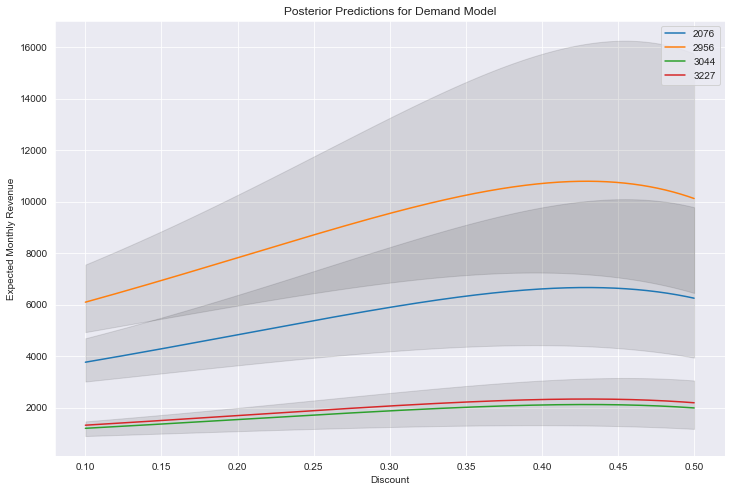

In [317]:
fig, ax = plt.subplots(figsize=(12,8))

# get coefficient estimates
results = az.summary(trace_1.posterior, kind="stats")
b = results['mean']

# plot base curve
x = np.linspace(0.1, 0.5, 1000)
# plt.plot(x, np.exp(b[0] + b[4]*x))

fam_id = np.argwhere(results.index.isin([str(x) for x in fams])).reshape(1, -1).ravel()

diff = []

# plot curves
for i in fam_id:
    
    avg_price = data2.loc[data2.ProductFamilyID.astype(str) == results.index[fam_id[0]], 'avg_price'].iloc[0]
    exp_demand = np.exp(b[0] + b[i] + b[-1]*x)
    revenue = avg_price*(1 - x)
    cost = data2.loc[data2.ProductFamilyID.astype(str) == results.index[fam_id[0]], 'avg_cost'].iloc[0]
    
    plt.plot(x, (revenue-cost)*exp_demand)
    
    l = np.exp(b[0] + b[i] + b[-1]*x)
    diff.append((l[-1] - l[0]))
    
#plt.legend(data_.ProductFamilyID.unique())
plt.legend(results.index[fam_id])

# add shade
# bottom = np.exp(results['hdi_3%'][0] + results['hdi_3%'][-1]*x)
# top = np.exp(results['hdi_97%'][0] + results['hdi_97%'][-1]*x)
    
# plt.fill_between(x, bottom, top, color='black', alpha=0.1)
    
for i in np.arange(3) + 1:
    bottom = (revenue-cost)*np.exp(results['hdi_3%'][0] + results['hdi_3%'][i] + results['hdi_3%'][-1]*x)
    top = (revenue-cost)*np.exp(results['hdi_97%'][0] + results['hdi_97%'][i] + results['hdi_97%'][-1]*x)
    
    plt.fill_between(x, bottom, top, color='black', alpha=0.1)
    
plt.title('Posterior Predictions for Demand Model')
plt.ylabel('Expected Monthly Revenue')
plt.xlabel('Discount')
plt.show()

In [59]:
# use bambi
model = bmb.Model(fml, data_, family="poisson")
inf_fish_alt = model.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(ProductFamilyID), discount]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.


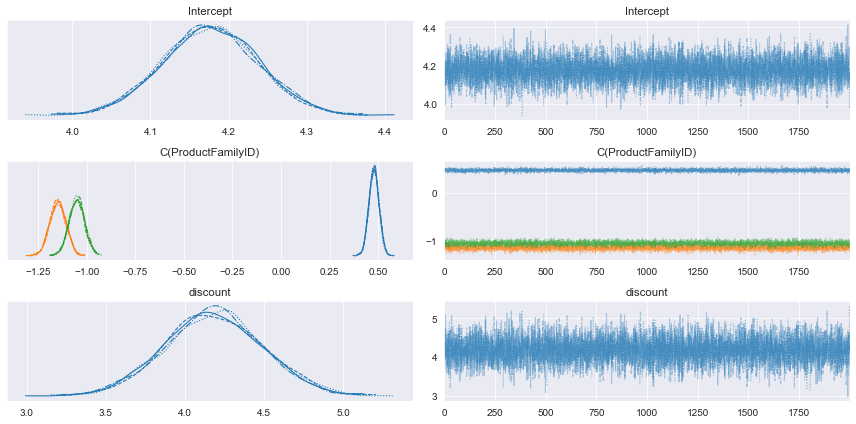

In [69]:
az.plot_trace(inf_fish_alt);
plt.tight_layout()

In [70]:
az.summary(np.exp(inf_fish_alt.posterior), kind="stats")

mean      sd  hdi_3%  hdi_97%
Intercept                 65.259   3.991  57.826   72.848
C(ProductFamilyID)[2956]   1.613   0.041   1.535    1.690
C(ProductFamilyID)[3044]   0.318   0.013   0.294    0.343
C(ProductFamilyID)[3227]   0.350   0.014   0.324    0.377
discount                  68.778  21.996  33.791  111.943

In [ ]:
mod = az.summary(np.exp(inf_fish_alt.posterior), kind="stats")
mod.

In [76]:
model.posterior_predictive(inf_fish_alt, draws=None)

Formula: quantity ~ C(ProductFamilyID) + discount
Family name: Poisson
Link: log
Observations: 72
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 12.4035)
    C(ProductFamilyID) ~ Normal(mu: [0. 0. 0.], sigma: [5.7735 5.7735 5.7735])
    discount ~ Normal(mu: 0.0, sigma: 67.9366)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [40]:
az.plot_ppc(inf_fish_alt, num_pp_samples=200);

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

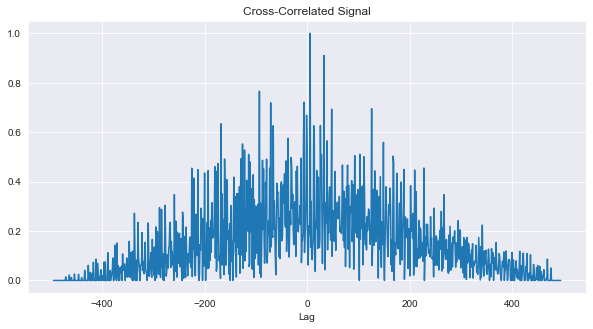

In [170]:
# cross-correlation between tier 1 demand and tier 2?
from scipy import signal
fig, ax = plt.subplots(figsize=(10, 5))

# get cross correlation and lags
corr = signal.correlate(data_[1], data_[2])
lags = signal.correlation_lags(len(data_[1]), len(data_[2]))

# normalize correlation
corr = corr/np.max(corr)

# labels
plt.plot(lags, corr)
ax.set_xlabel('Lag')
ax.set_title('Cross-Correlated Signal')

plt.show()

#
Use Kolmogorov-Smirnov test to check to difference in distrubtions in average quantity ordered per day when there is at least 1 order.

KstestResult(statistic=0.06096196868008948, pvalue=0.9859092920271297)



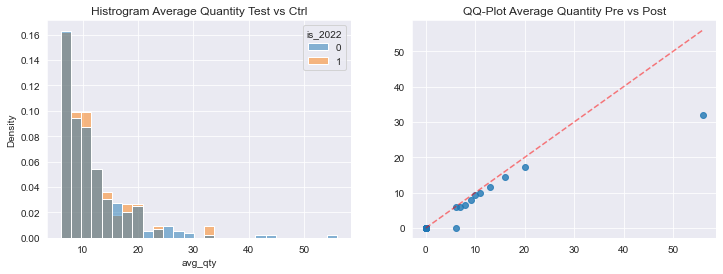

In [293]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# hist plot
sns.histplot(
    data=data[
        (data.Tier == 2) &
        (data.avg_qty != 0)
    ],
    x='avg_qty',
    hue='is_2022',
    common_norm=False,
    stat="density",
    ax=ax[0]
)
ax[0].set_title('Histrogram Average Quantity Test vs Ctrl')

# qq-plot ctrl vs test
steps = 100
ctrl_quantiles = [data.loc[(data.is_2022 == 0) & (data.Tier == 2), 'avg_qty'].quantile(x) for x in np.linspace(0, 1, steps)]
test_quantiles = [data.loc[(data.is_2022 == 1) & (data.Tier == 2), 'avg_qty'].quantile(x) for x in np.linspace(0, 1, steps)]

ax[1].scatter(ctrl_quantiles, test_quantiles, alpha=0.8)

# add line slope 1
x = np.linspace(min([min(ctrl_quantiles), min(test_quantiles)]), max([max(ctrl_quantiles), max(test_quantiles)]))
ax[1].plot(x, x, c='red', linestyle='--', alpha=0.5)
ax[1].set_title('QQ-Plot Average Quantity Pre vs Post')

x = data[
        (data.Tier == 2)
        & (data.avg_qty != 0)
]
    
samp1 = x[x.is_2022 == 0]
samp2 = x[x.is_2022 == 1]
    
print(stats.ks_2samp(data1=samp1.avg_qty , data2=samp2.avg_qty))
print()

plt.show()

KstestResult(statistic=0.9130434782608695, pvalue=0.007692307692307776)


Text(0.5, 1.0, 'QQ-Plot Average Quantity Pre vs Post')

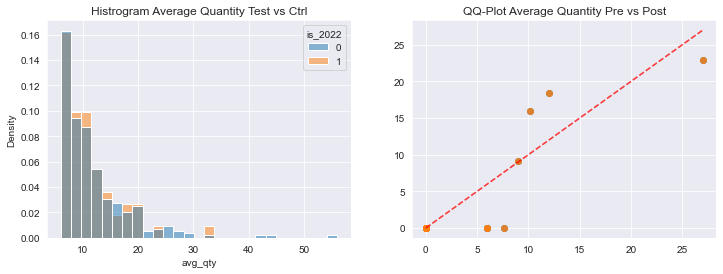

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# pick family
i = 2

# hist plot
sns.histplot(
    data=data[
        (data.Tier == 2)
        & (data.avg_qty != 0)
    ],
    x='avg_qty',
    hue='is_2022',
    common_norm=False,
    stat="density",
    ax=ax[0]
)
ax[0].set_title('Histrogram Average Quantity Test vs Ctrl')

# qq-plot ctrl vs test
steps = 100
ctrl_quantiles = [
    data.loc[
        (data.is_2022 == 0) & 
        (data.Tier ==2) &
        (data.ProductFamilyID == fams[i]), 
        'avg_qty'
    ].quantile(x) for x in np.linspace(0, 1, steps)
]
test_quantiles = [
    data.loc[
        (data.is_2022 == 1) & 
        (data.Tier == 2) &
        (data.ProductFamilyID == fams[i]), 
        'avg_qty'
    ].quantile(x) for x in np.linspace(0, 1, steps)
]

ax[1].scatter(ctrl_quantiles, test_quantiles, alpha=0.8)

# add line slope 1
x = np.linspace(min([min(ctrl_quantiles), min(test_quantiles)]), max([max(ctrl_quantiles), max(test_quantiles)]))
ax[1].plot(x, x, c='red', linestyle='--', alpha=0.5)
ax[1].set_title('QQ-Plot Average Quantity Pre vs Post')

x = data[
        (data.Tier == 2)
        & (data.avg_qty != 0)
        & (data.ProductFamilyID == fams[i])
]
    
samp1 = x[x.is_2022 == 0]
samp2 = x[x.is_2022 == 1]
    
print(stats.ks_2samp(data1=samp1.avg_qty , data2=samp2.avg_qty))

ax[1].scatter(ctrl_quantiles, test_quantiles, alpha=0.8)

# add line slope 1
x = np.linspace(min([min(ctrl_quantiles), min(test_quantiles)]), max([max(ctrl_quantiles), max(test_quantiles)]))
ax[1].plot(x, x, c='red', linestyle='--', alpha=0.5)
ax[1].set_title('QQ-Plot Average Quantity Pre vs Post')

In [273]:
# measure difference in means manually
i = 0
x = data[
    (data.Tier == 2) &
    (
        (data.ProductFamilyID == fams[i]) |
        (data.ProductFamilyID == ctrl[i])
    )
].groupby(['ProductFamilyID', 'is_2022'], as_index=False)[['profit', 'revenue', 'orders', 'customers', 'quantity']].mean()

a = x.loc[(x.ProductFamilyID == fams[i]) & (x.is_2022 == 0), 'quantity'].iloc[0] - x.loc[(x.ProductFamilyID == ctrl[i]) & (x.is_2022 == 0), 'quantity'].iloc[0]
b = x.loc[(x.ProductFamilyID == fams[i]) & (x.is_2022 == 1), 'quantity'].iloc[0] - x.loc[(x.ProductFamilyID == ctrl[i]) & (x.is_2022 == 1), 'quantity'].iloc[0]

print('DD:', b - a)

DD: 2.2163489736070385


In [281]:
# OLS DD
for i in np.arange(len(fams)):
    print(fams[i])
    print(
        smf.ols('quantity ~ is_2022*treated', 
                data=data[
                    (data.Tier == 2) &
                    (
                        (data.ProductFamilyID == fams[i]) |
                        (data.ProductFamilyID == ctrl[i])
                    )
                    
                ].dropna()).fit().summary().tables[1]
    )

2956
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.2317      0.728      7.186      0.000       3.803       6.661
is_2022            -3.1817      1.670     -1.905      0.057      -6.460       0.096
treated            -0.9413      1.030     -0.914      0.361      -2.962       1.079
is_2022:treated     2.2163      2.362      0.938      0.348      -2.419       6.852
3044
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4751      0.271      5.444      0.000       0.943       2.007
is_2022            -0.0126      0.622     -0.020      0.984      -1.232       1.207
treated            -0.6540      0.383     -1.707      0.088      -1.406       0.098
is_2022:treated    -0.0085      0.879     -0.010      0.992      -

In [274]:
# fit linear regression
for i in np.arange(len(fams)):
    print(fams[i])
    print(
        smf.ols('revenue ~ is_2022*treated', 
                data=data[
                    (data.Tier == 2) &
                    (
                        (data.ProductFamilyID == fams[i]) |
                        (data.ProductFamilyID == ctrl[i])
                    )
                ].dropna()).fit().summary().tables[1]
    )

2956
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         395.5232     57.731      6.851      0.000     282.208     508.838
is_2022          -210.4807    132.436     -1.589      0.112    -470.426      49.465
treated           -53.0896     81.644     -0.650      0.516    -213.341     107.162
is_2022:treated   129.4936    187.293      0.691      0.490    -238.125     497.112
3044
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         349.6246     78.258      4.468      0.000     196.020     503.230
is_2022            48.3054    179.525      0.269      0.788    -304.067     400.677
treated          -182.2792    110.674     -1.647      0.100    -399.509      34.951
is_2022:treated   -18.3008    253.887     -0.072      0.943    -51

In [275]:
# fit linear regression
for i in np.arange(len(fams)):
    print(fams[i])
    print(
        smf.ols('orders ~ is_2022*treated', 
                data=data[
                    (data.Tier == 2) &
                    (
                        (data.ProductFamilyID == fams[i]) |
                        (data.ProductFamilyID == ctrl[i])
                    )
                ].dropna()).fit().summary().tables[1]
    )

2956
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3695      0.053      7.023      0.000       0.266       0.473
is_2022            -0.1570      0.121     -1.301      0.194      -0.394       0.080
treated            -0.0088      0.074     -0.118      0.906      -0.155       0.137
is_2022:treated     0.0588      0.171      0.344      0.731      -0.276       0.394
3044
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1056      0.021      5.009      0.000       0.064       0.147
is_2022             0.0444      0.048      0.919      0.358      -0.050       0.139
treated            -0.0176      0.030     -0.590      0.555      -0.076       0.041
is_2022:treated    -0.0324      0.068     -0.474      0.636      -

In [276]:
# fit linear regression
for i in np.arange(len(fams)):
    print(fams[i])
    print(
        smf.ols('customers ~ is_2022*treated', 
                data=data[
                    (data.Tier == 2) &
                    (
                        (data.ProductFamilyID == fams[i]) |
                        (data.ProductFamilyID == ctrl[i])
                    )
                ].dropna()).fit().summary().tables[1]
    )

2956
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2023      0.038      5.390      0.000       0.129       0.276
is_2022            -0.0148      0.086     -0.172      0.863      -0.184       0.154
treated            -0.0029      0.053     -0.055      0.956      -0.107       0.101
is_2022:treated     0.0654      0.122      0.537      0.591      -0.174       0.304
3044
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0645      0.018      3.624      0.000       0.030       0.099
is_2022             0.0605      0.041      1.481      0.139      -0.020       0.141
treated             0.0117      0.025      0.466      0.641      -0.038       0.061
is_2022:treated    -0.0367      0.058     -0.636      0.525      -

### Measuring Demand
Measure demand of similar item clusters. We could do this by clustering items frequently purchased together. This is important because the of the "One-Stop-Shop" phenomena, whereby the lack of availability of one item might affect the demand of another item. For instance, demand for machine vision imaging lenses may depend in part on camera availability, or vice versa. Therefore, we also have to take into account the snapshot stock availability history. Critically, we need to estimate the number of lost sales, which is defined as the number of customers who would have purchased had the product been in stock.

Can we assume that the number of customers who visit the store but did not purchase anything is negligible?

https://www8.gsb.columbia.edu/cprm/sites/cprm/files/files/Working%20Papers/2009-2-PrimaryDemandEM.pdf

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3583836

https://arxiv.org/pdf/2006.11450.pdf

Python packages:

pyBLP
https://pyblp.readthedocs.io/en/stable/introduction.html

pylogit
https://github.com/timothyb0912/pylogit

In [ ]:
cnxn_str = ("Driver={ODBC Driver 17 for SQL Server};"
            "Server=BI;"
            "Database=BI_Production;"
            "Trusted_Connection=yes;")

cnxn = pyodbc.connect(cnxn_str)

cursor = cnxn.cursor()

query = """
SELECT
    MIN(sf.Date) as 'min_date'
    ,sf.Qty
    ,sf.Matnr
    ,COUNT(*) as 'count'
    ,AVG(sf.Unit_Price) as 'avg'
    ,STDEV(sf.Unit_Price) as 'std'

FROM SalesFacts sf
WHERE sf.Type = 'Booking' 
    AND sf.Customer_group != 'Subsidiaries' 
    AND sf.Date >= DATEADD(month, -12, GETDATE())
GROUP BY sf.Doc_Currency, sf.Qty, sf.Matnr
"""
cursor.execute(query).fetchall()

data = pd.read_sql(query, cnxn)
data.fillna(0, inplace=True)
data.head()